In [1]:
from __future__ import division


import numpy as np
import pandas as pd


import itertools
import math

import matplotlib.pyplot as plt
from random import randint
from matplotlib import style
import seaborn as sns

from sklearn import metrics

In [2]:
colnames=['date','page_viewed','user_id','cohort_id','ip']
df = pd.read_csv('anonymized-curriculum-access.txt',          
                 engine='python',
                 header=None,
                 index_col=False,
                 names=colnames,
                 sep=r'\s(?=(?:[^"]*"[^"]*")*[^"]*$)(?![^\[]*\])',
                 na_values='"-"',
                 usecols=[0,2,3,4,5]
)

In [3]:
df.head()

,date,page_viewed,user_id,cohort_id,ip
0,2018-01-26,/,1,8.0,97.105.19.61
1,2018-01-26,java-ii,1,8.0,97.105.19.61
2,2018-01-26,java-ii/object-oriented-programming,1,8.0,97.105.19.61
3,2018-01-26,slides/object_oriented_programming,1,8.0,97.105.19.61
4,2018-01-26,javascript-i/conditionals,2,22.0,97.105.19.61


In [4]:
df = df.dropna()
df.cohort_id = df.cohort_id.astype('int')
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 219070 entries, 0 to 233527
Data columns (total 5 columns):
date           219070 non-null object
page_viewed    219070 non-null object
user_id        219070 non-null int64
cohort_id      219070 non-null int64
ip             219070 non-null object
dtypes: int64(2), object(3)
memory usage: 10.0+ MB
None


,date,page_viewed,user_id,cohort_id,ip
0,2018-01-26,/,1,8,97.105.19.61
1,2018-01-26,java-ii,1,8,97.105.19.61
2,2018-01-26,java-ii/object-oriented-programming,1,8,97.105.19.61
3,2018-01-26,slides/object_oriented_programming,1,8,97.105.19.61
4,2018-01-26,javascript-i/conditionals,2,22,97.105.19.61


In [5]:
cohort_names = pd.read_csv('cohort_name_to_id.csv')
cohort_dates = pd.read_csv('cohort_dates.csv', index_col=False)

In [6]:
cohort_names.head()

,name,id
0,Arches,1
1,Badlands,2
2,Carlsbad,3
3,Denali,4
4,Everglades,5


In [7]:
cohort_names.rename(columns={'id ': 'cohort_id'}, inplace=True)
df = df.merge(cohort_names, on='cohort_id', how='left')

In [8]:
cohort_dates = cohort_dates[['name', 'start_date', 'end_date']]
df = df.merge(cohort_dates, on='name', how='left')

In [9]:
df.head()

,date,page_viewed,user_id,cohort_id,ip,name,start_date,end_date
0,2018-01-26,/,1,8,97.105.19.61,Hampton,2015-09-22,2016-02-06
1,2018-01-26,java-ii,1,8,97.105.19.61,Hampton,2015-09-22,2016-02-06
2,2018-01-26,java-ii/object-oriented-programming,1,8,97.105.19.61,Hampton,2015-09-22,2016-02-06
3,2018-01-26,slides/object_oriented_programming,1,8,97.105.19.61,Hampton,2015-09-22,2016-02-06
4,2018-01-26,javascript-i/conditionals,2,22,97.105.19.61,Teddy,2018-01-08,2018-05-17


In [10]:
df['date'] = pd.to_datetime(df['date'])
df['start_date'] = pd.to_datetime(df['start_date'])
df['end_date'] = pd.to_datetime(df['end_date'])

In [11]:
df['after_course'] = (df.date > df.end_date).astype(int)

In [12]:
df['after_course'].head()

0    1
1    1
2    1
3    1
4    0
Name: after_course, dtype: int64

In [13]:
df.head()

,date,page_viewed,user_id,cohort_id,ip,name,start_date,end_date,after_course
0,2018-01-26,/,1,8,97.105.19.61,Hampton,2015-09-22,2016-02-06,1
1,2018-01-26,java-ii,1,8,97.105.19.61,Hampton,2015-09-22,2016-02-06,1
2,2018-01-26,java-ii/object-oriented-programming,1,8,97.105.19.61,Hampton,2015-09-22,2016-02-06,1
3,2018-01-26,slides/object_oriented_programming,1,8,97.105.19.61,Hampton,2015-09-22,2016-02-06,1
4,2018-01-26,javascript-i/conditionals,2,22,97.105.19.61,Teddy,2018-01-08,2018-05-17,0


In [14]:
# aggregate by user id per date, count number of page views on the condition the view was made post-course.
df_agg = df[df.after_course == 1].groupby(['date','user_id'])['page_viewed'].\
                        count().\
                    reset_index().\
                    rename(index=str, 
                       columns={'page_viewed': 'hits'})

In [15]:
df_agg.head()

,date,user_id,hits
0,2018-01-26,1,7
1,2018-01-26,11,19
2,2018-01-26,21,2
3,2018-01-26,26,3
4,2018-01-26,37,4


In [16]:
# create crosstab to represent the same data as the aggregation
user_views = pd.crosstab(df[df.after_course == 1].date, df[df.after_course == 1].user_id)

In [17]:
#index the crosstab with datetime
user_views.index = pd.to_datetime(user_views.index)

In [18]:
# resample by week, assign to new frame
us_views_by_week = user_views.resample('W').sum().loc[:, 0:25]

Text(0.5, 1.0, 'Post-Course Views by User Over Time')

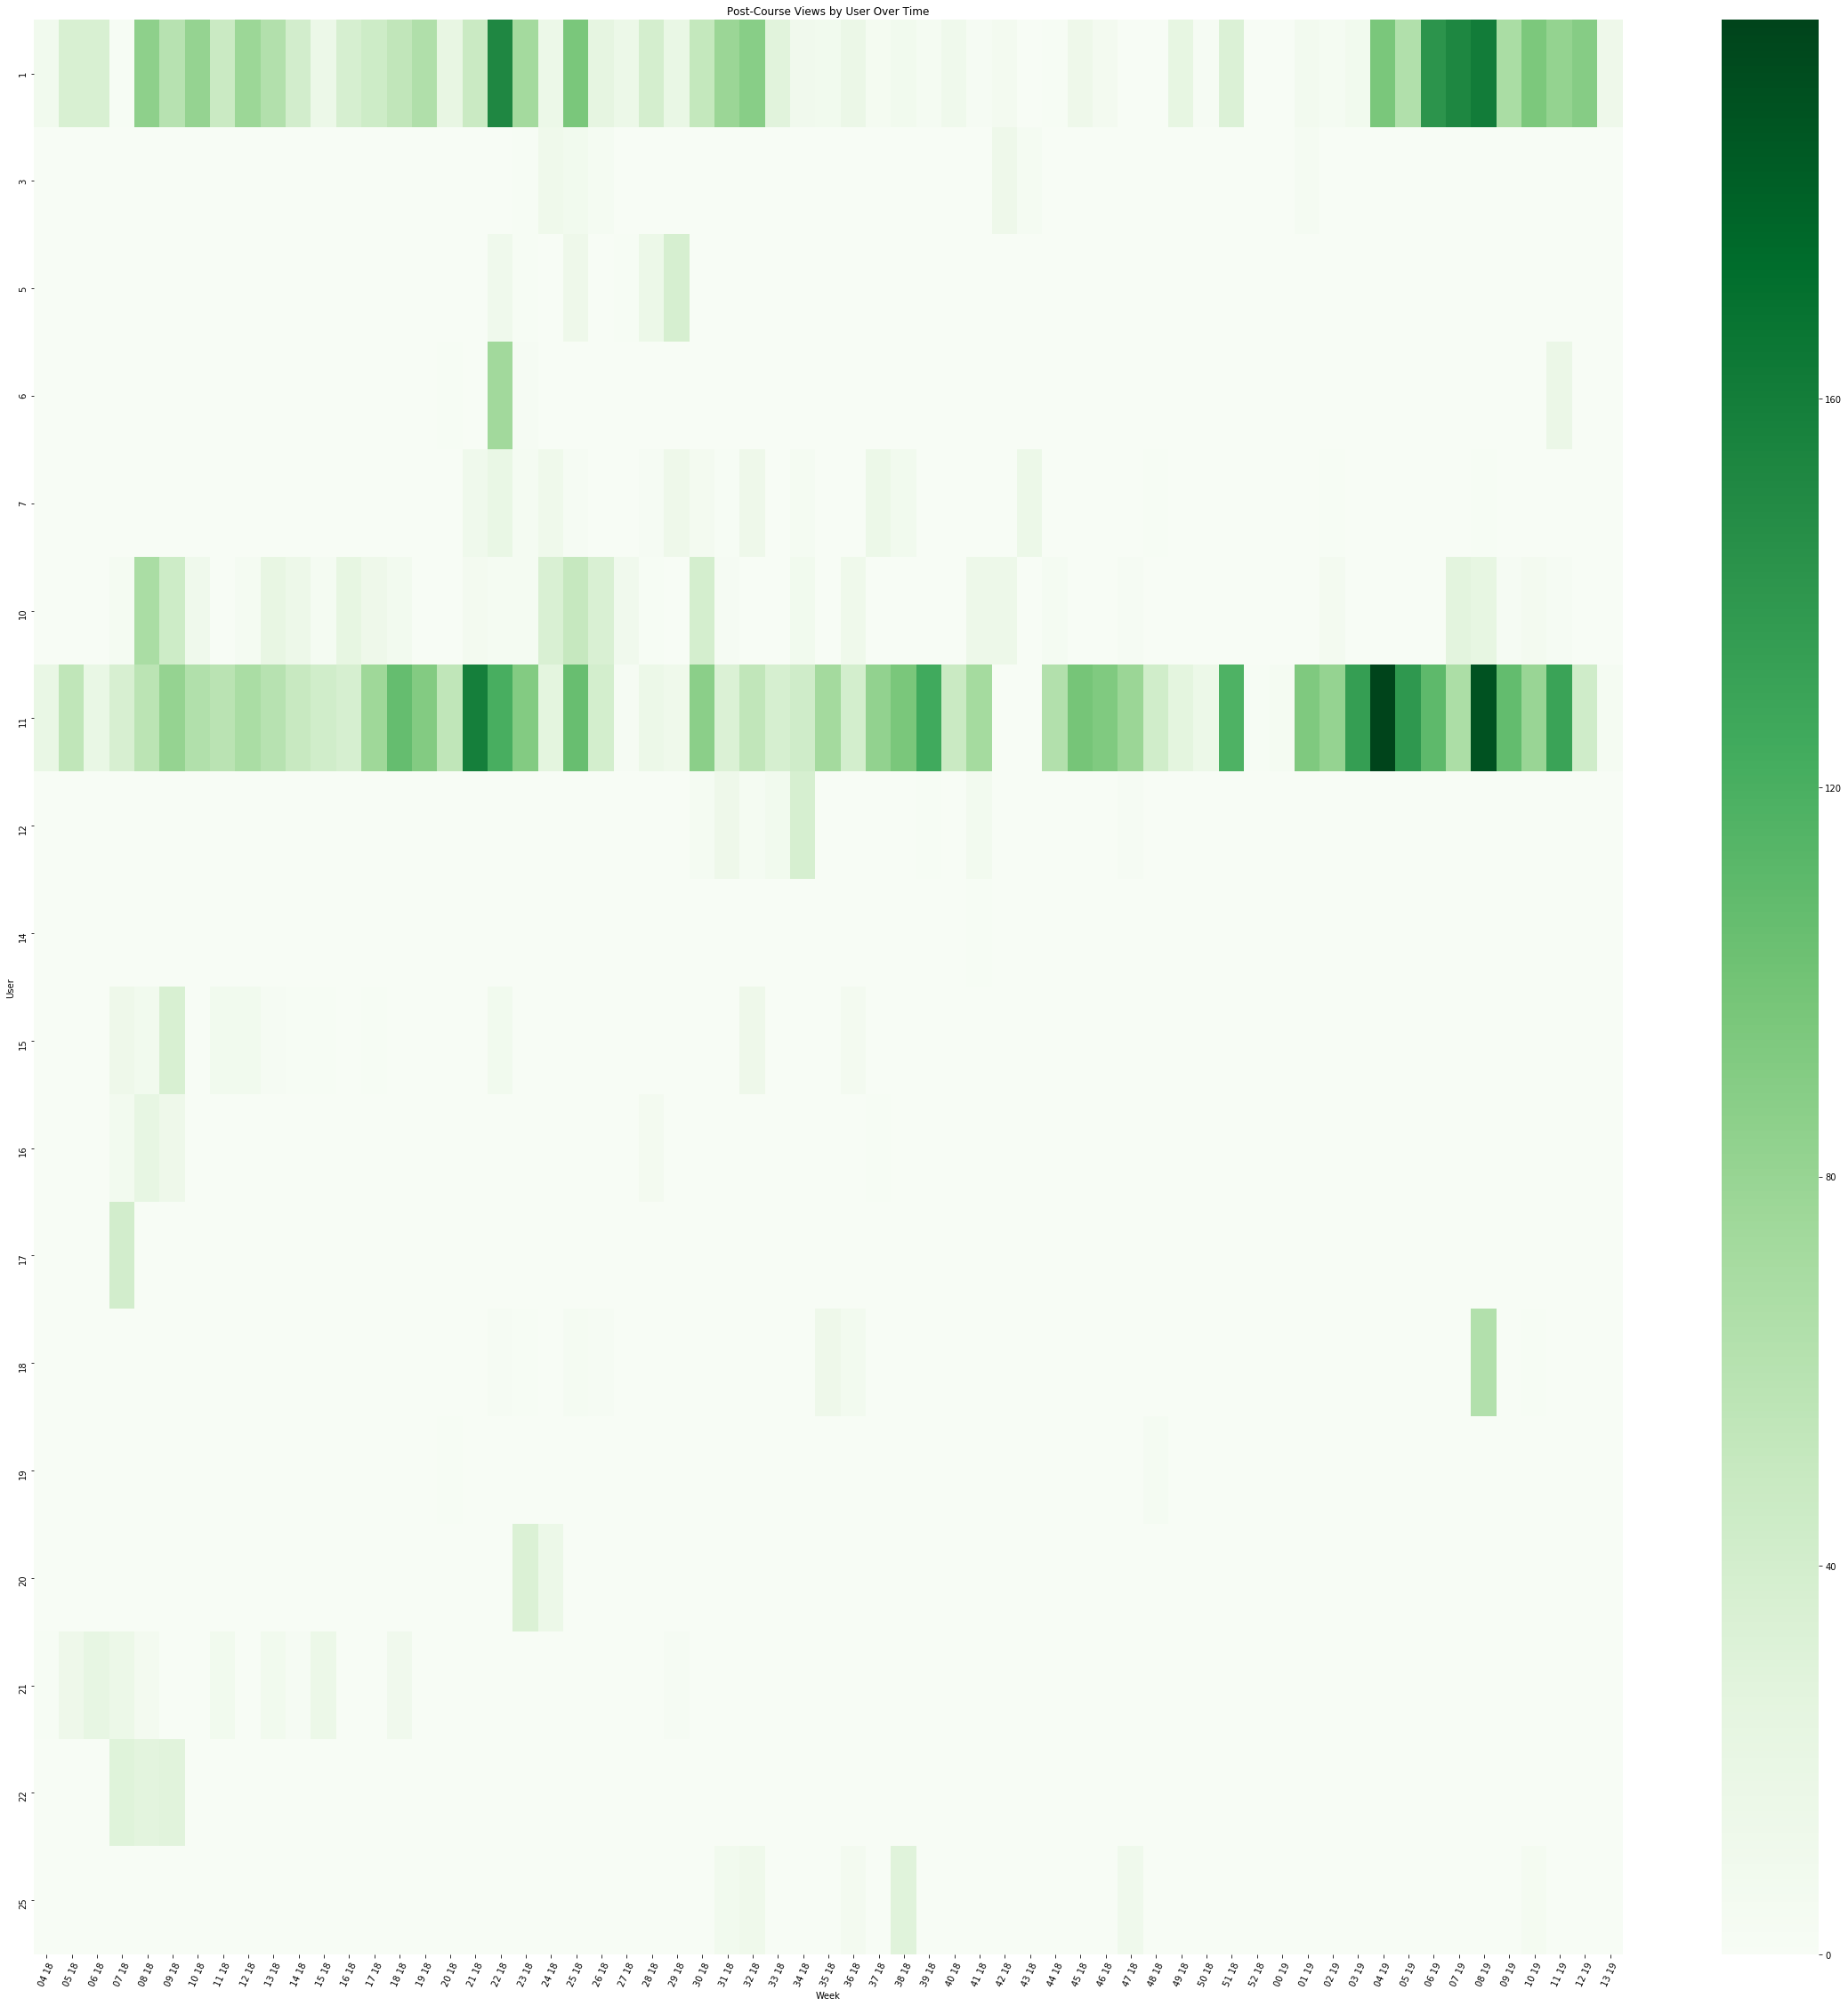

In [19]:
plt.figure(figsize=(40,40))
sns.heatmap(us_views_by_week.T, cmap='Greens')
# assign ticks and labels from plot
ticks, labels = plt.xticks()
# remake labels using datetime formatting that is preferable
labels = us_views_by_week.index.strftime('%W %y')
# reassign xticks with new labels
plt.xticks(ticks, labels)
# rotate xticks
plt.xticks(ticks, labels, rotation=65)
# label y axis
plt.ylabel('User')
# label x axis
plt.xlabel('Week')
# label title
plt.title('Post-Course Views by User Over Time')



users to watch: 1, 11,

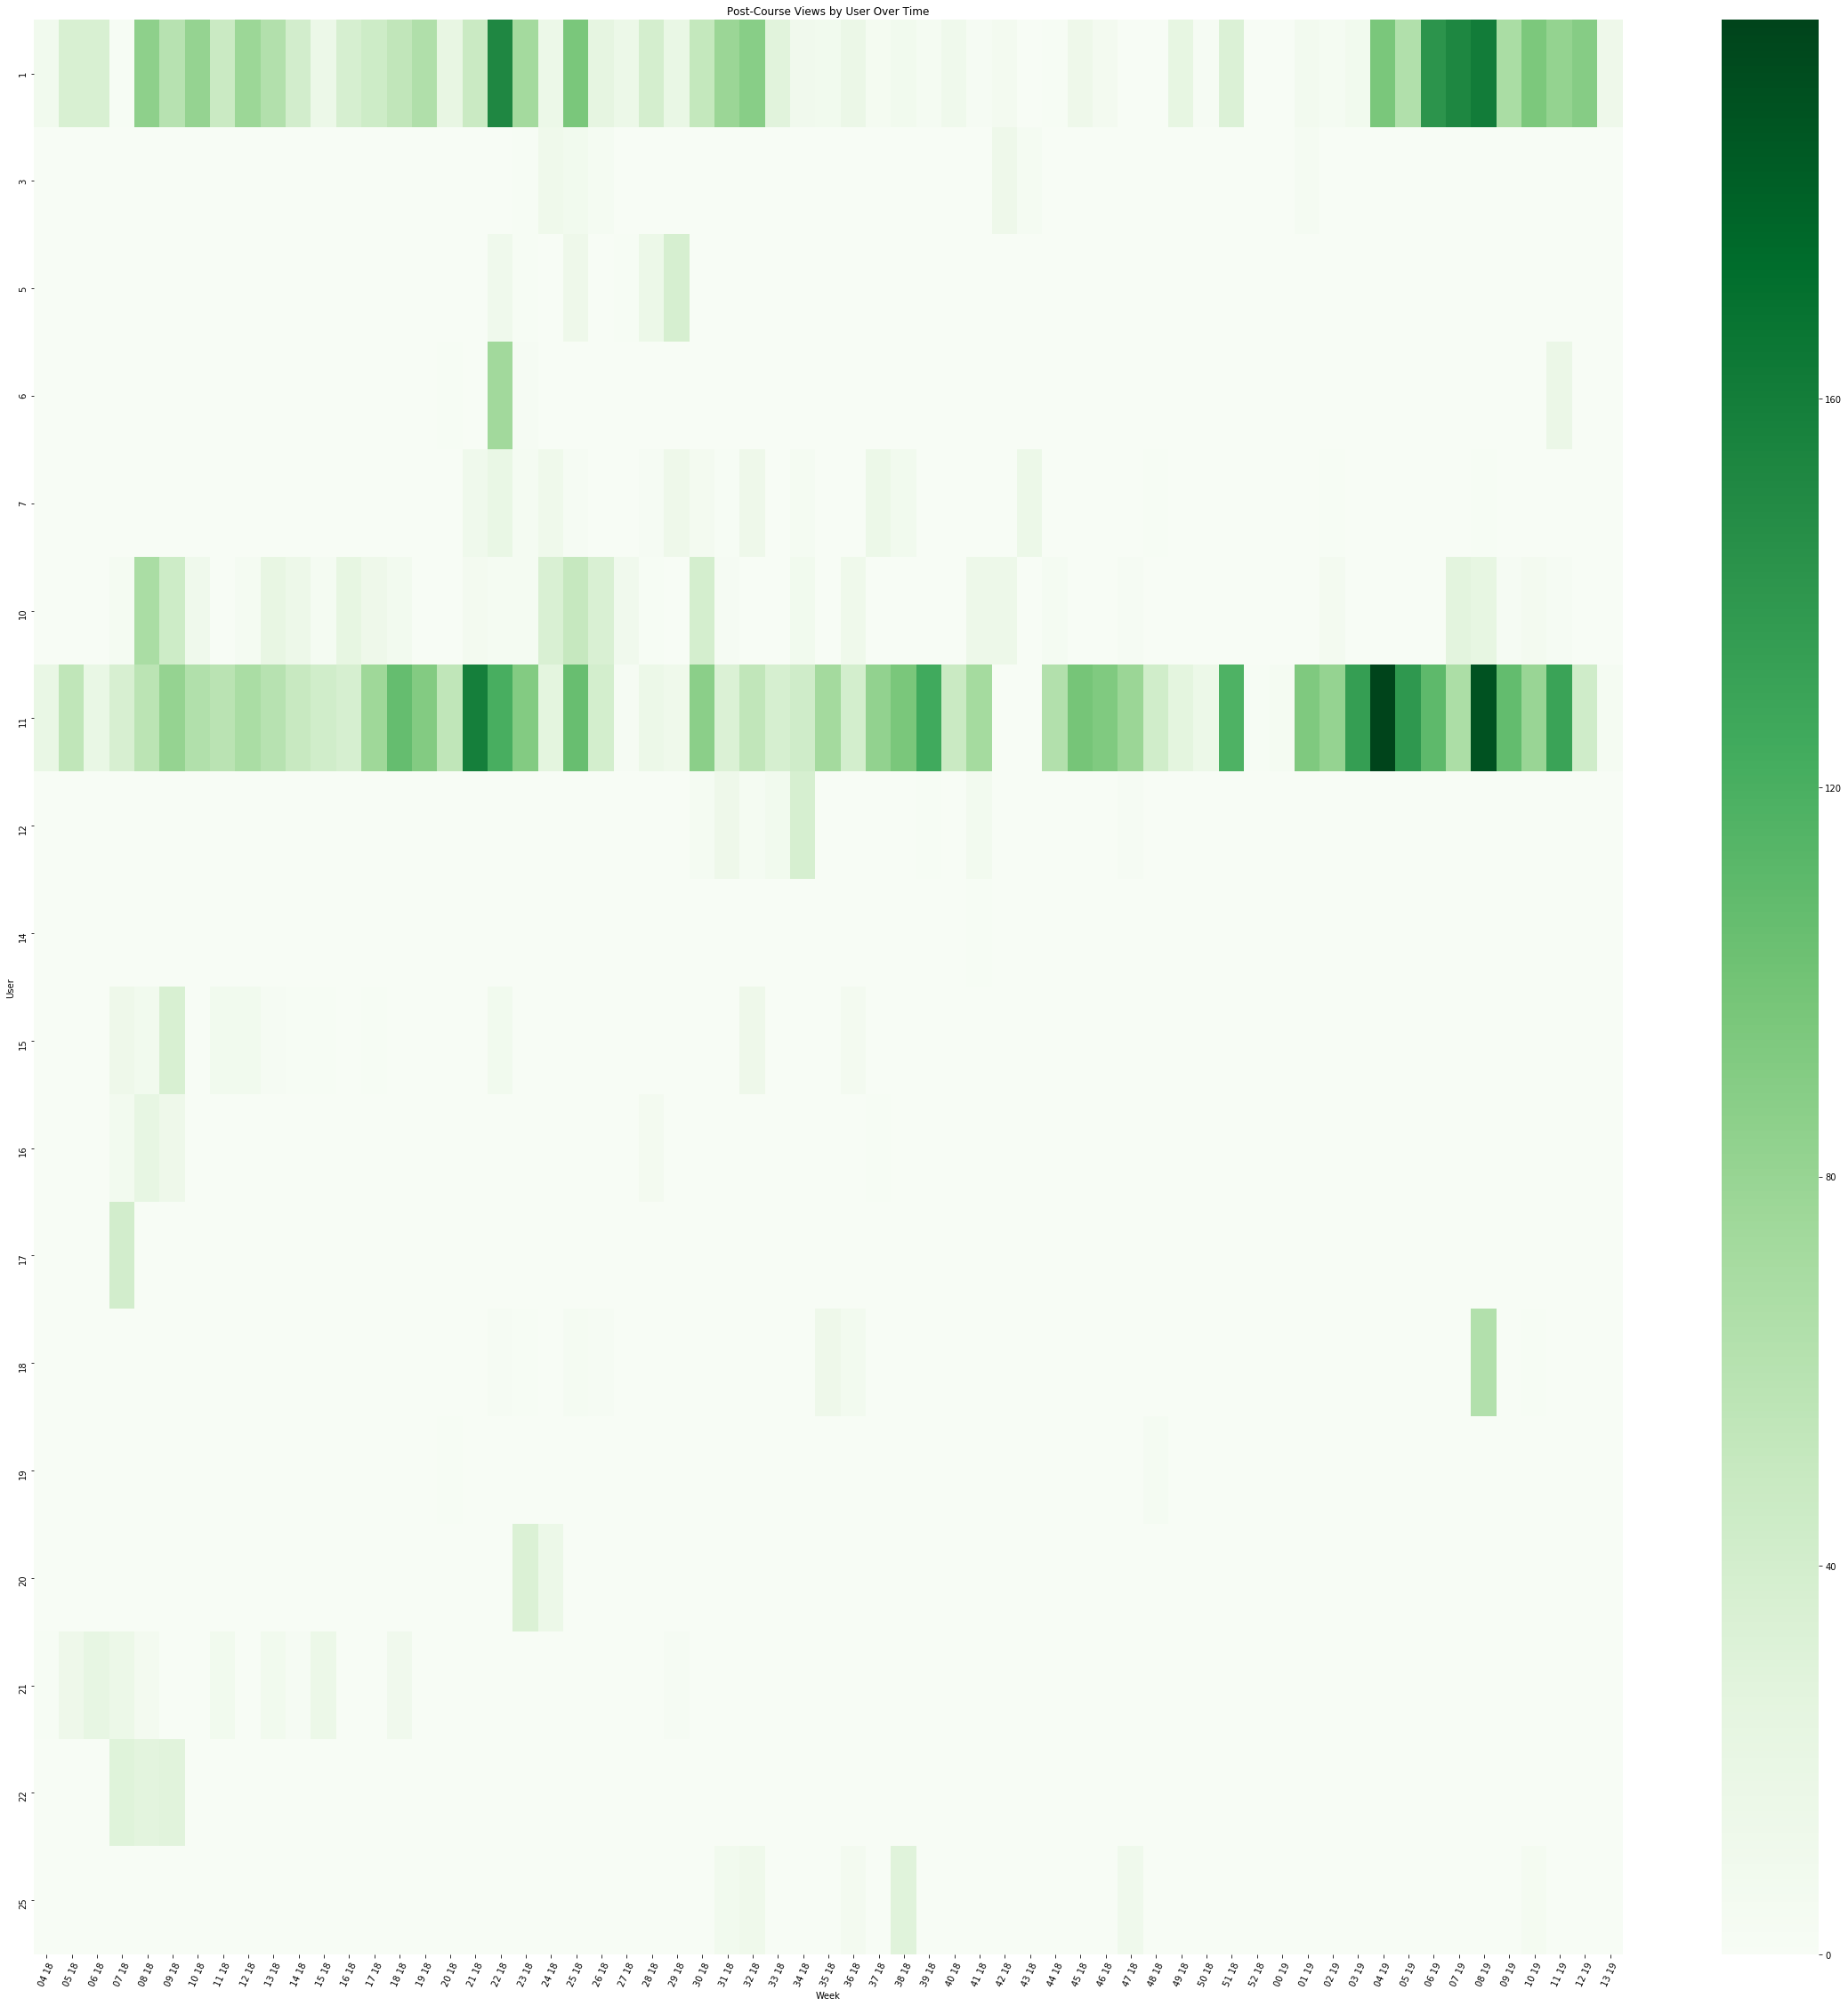

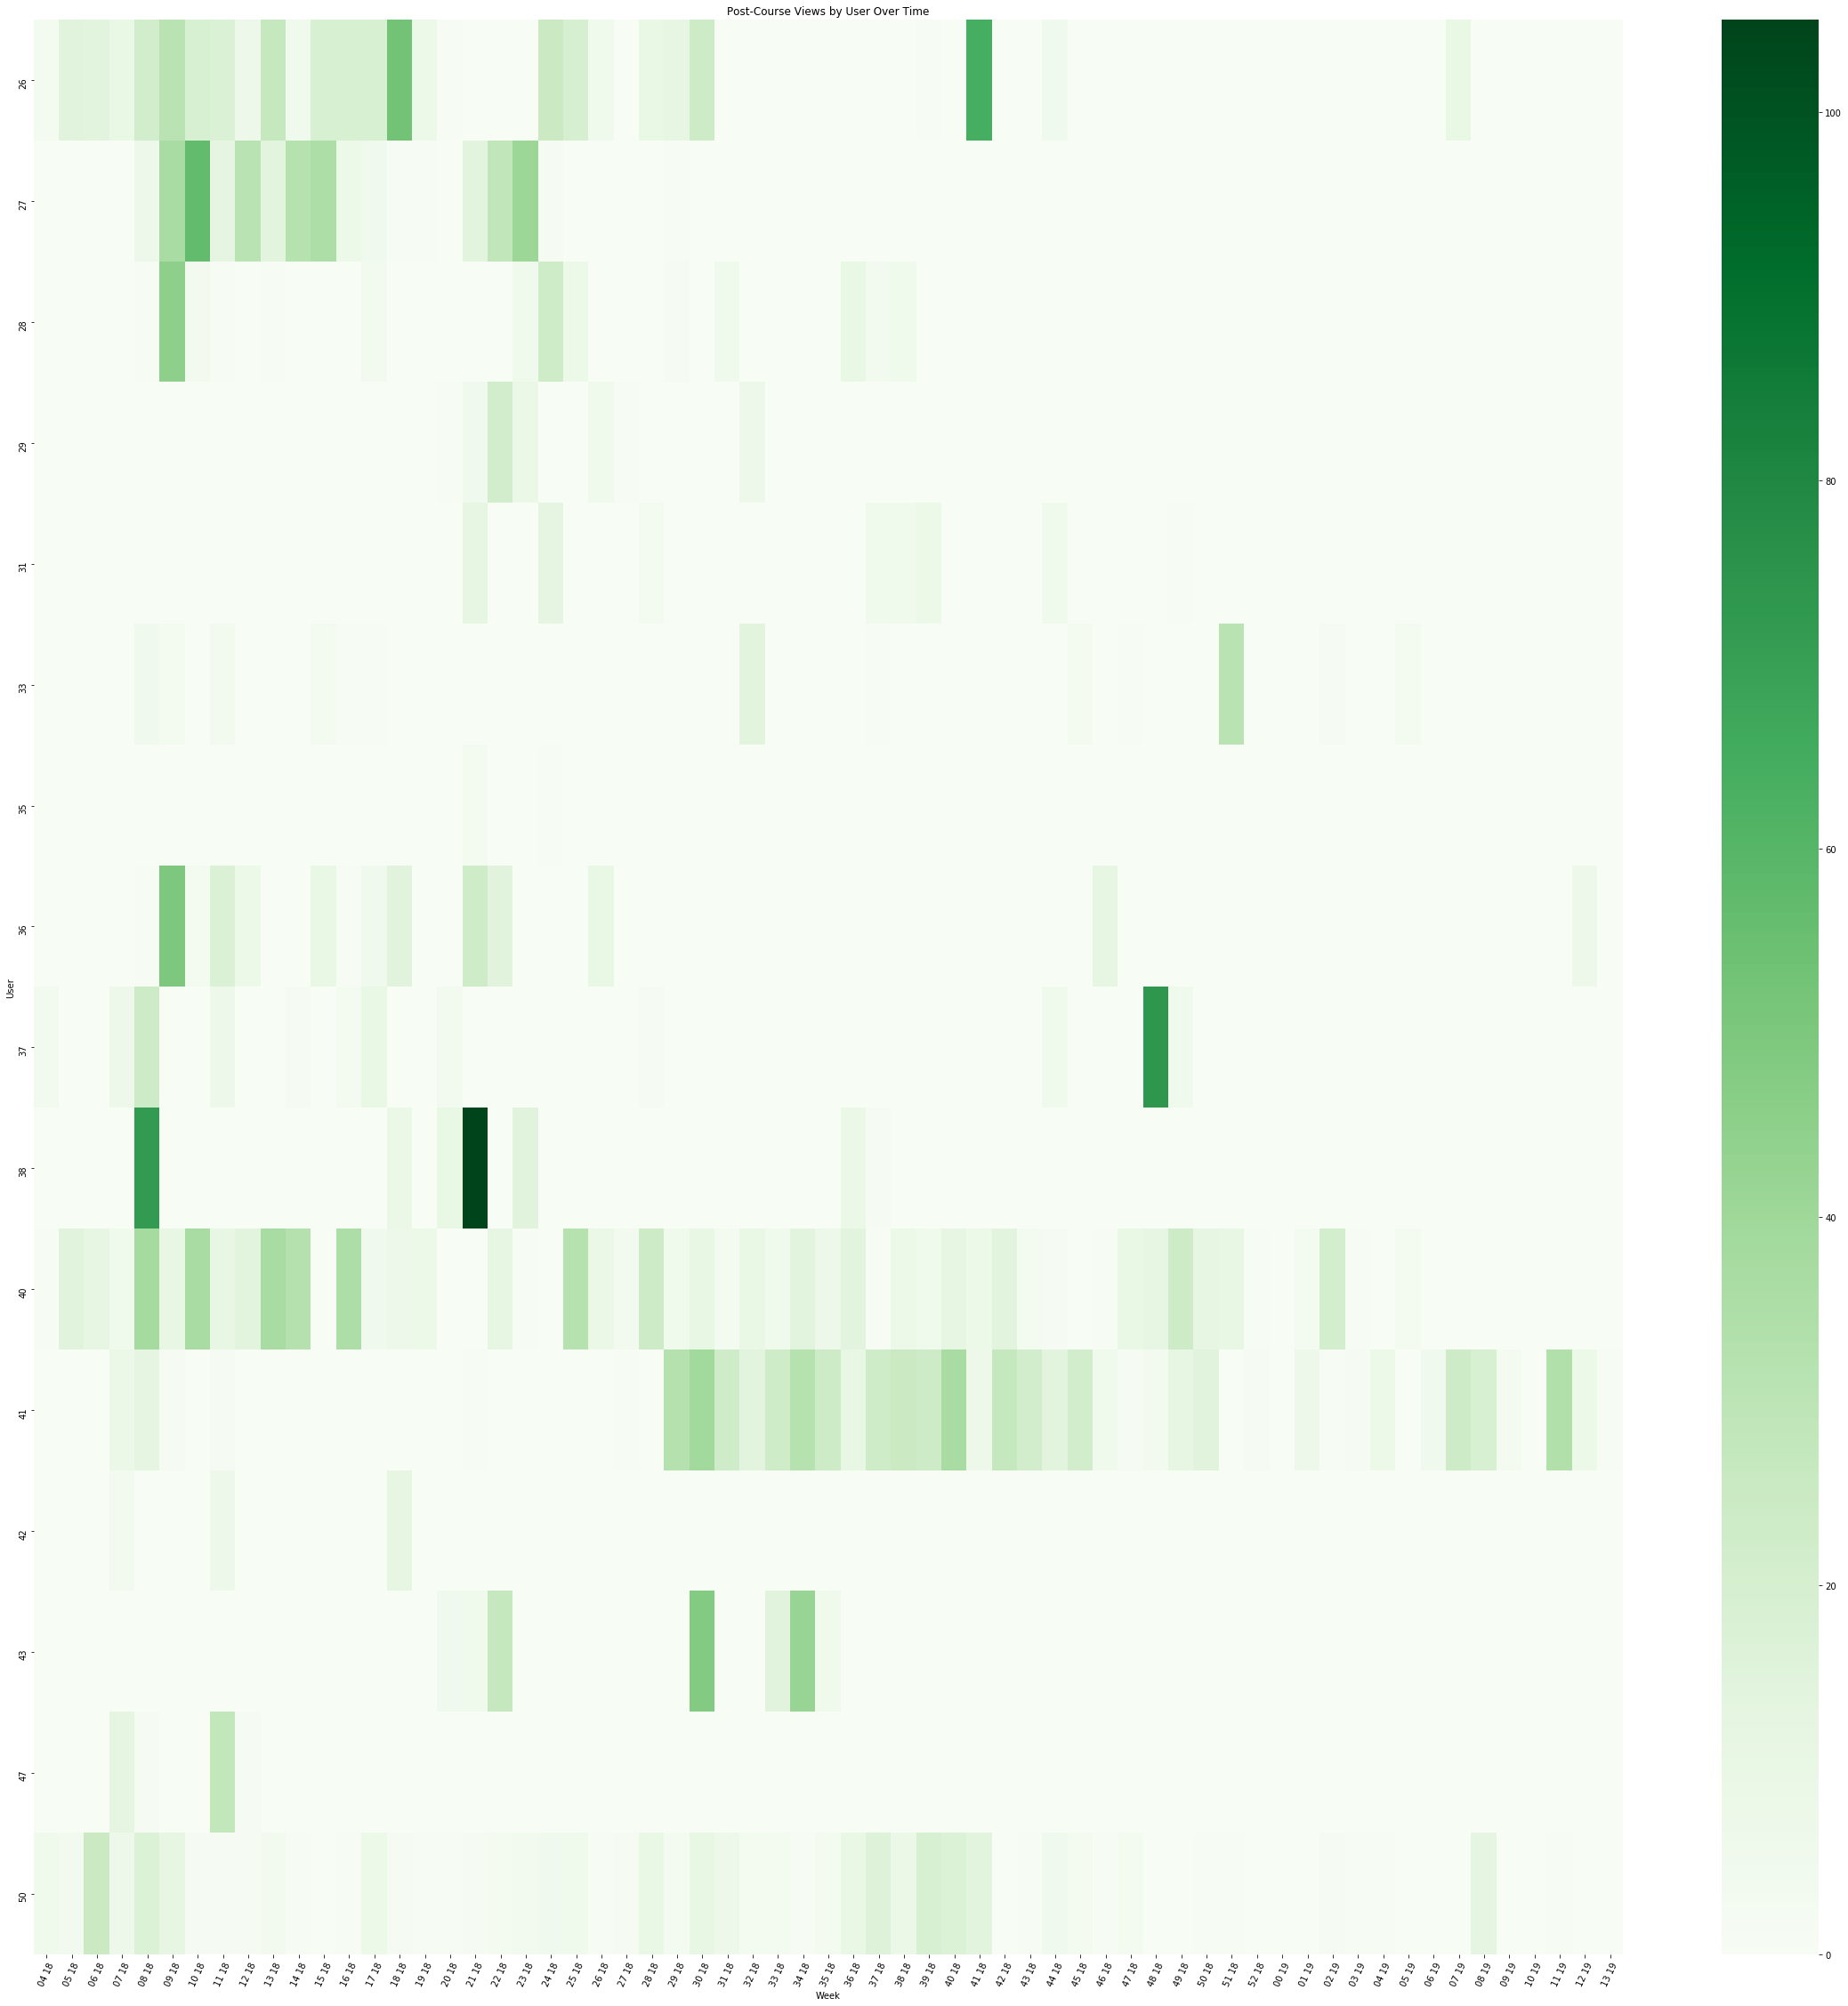

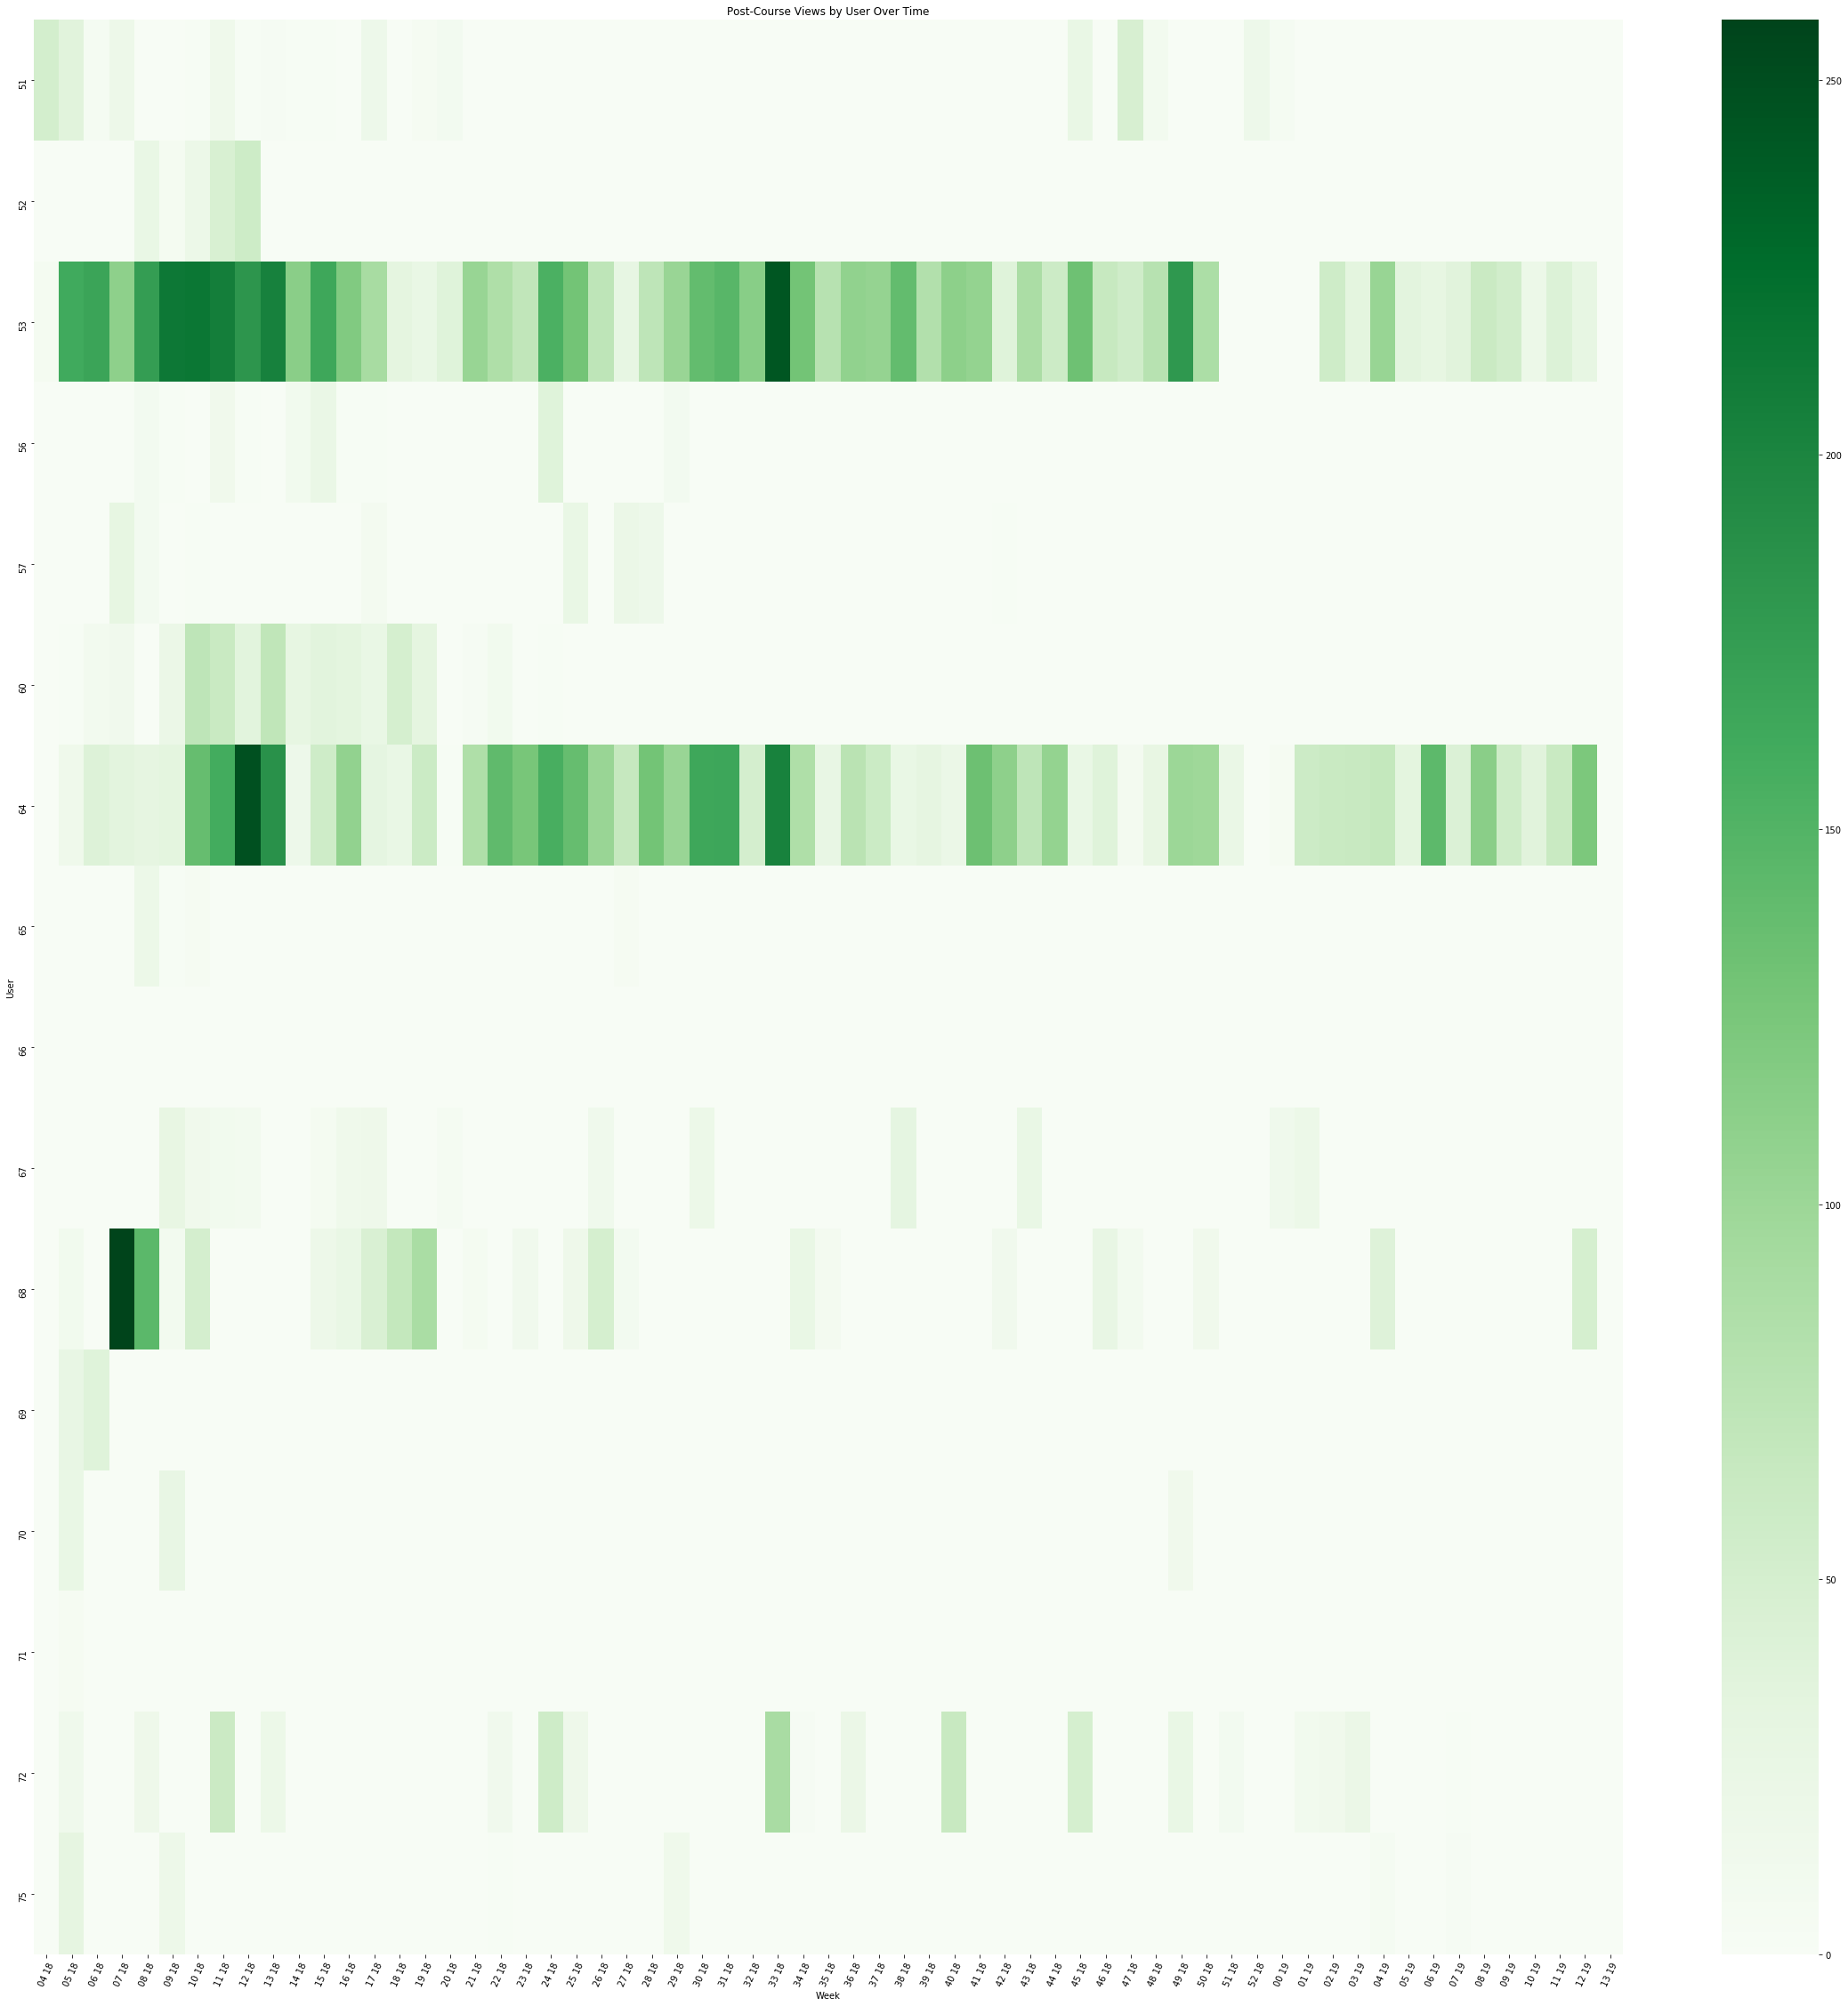

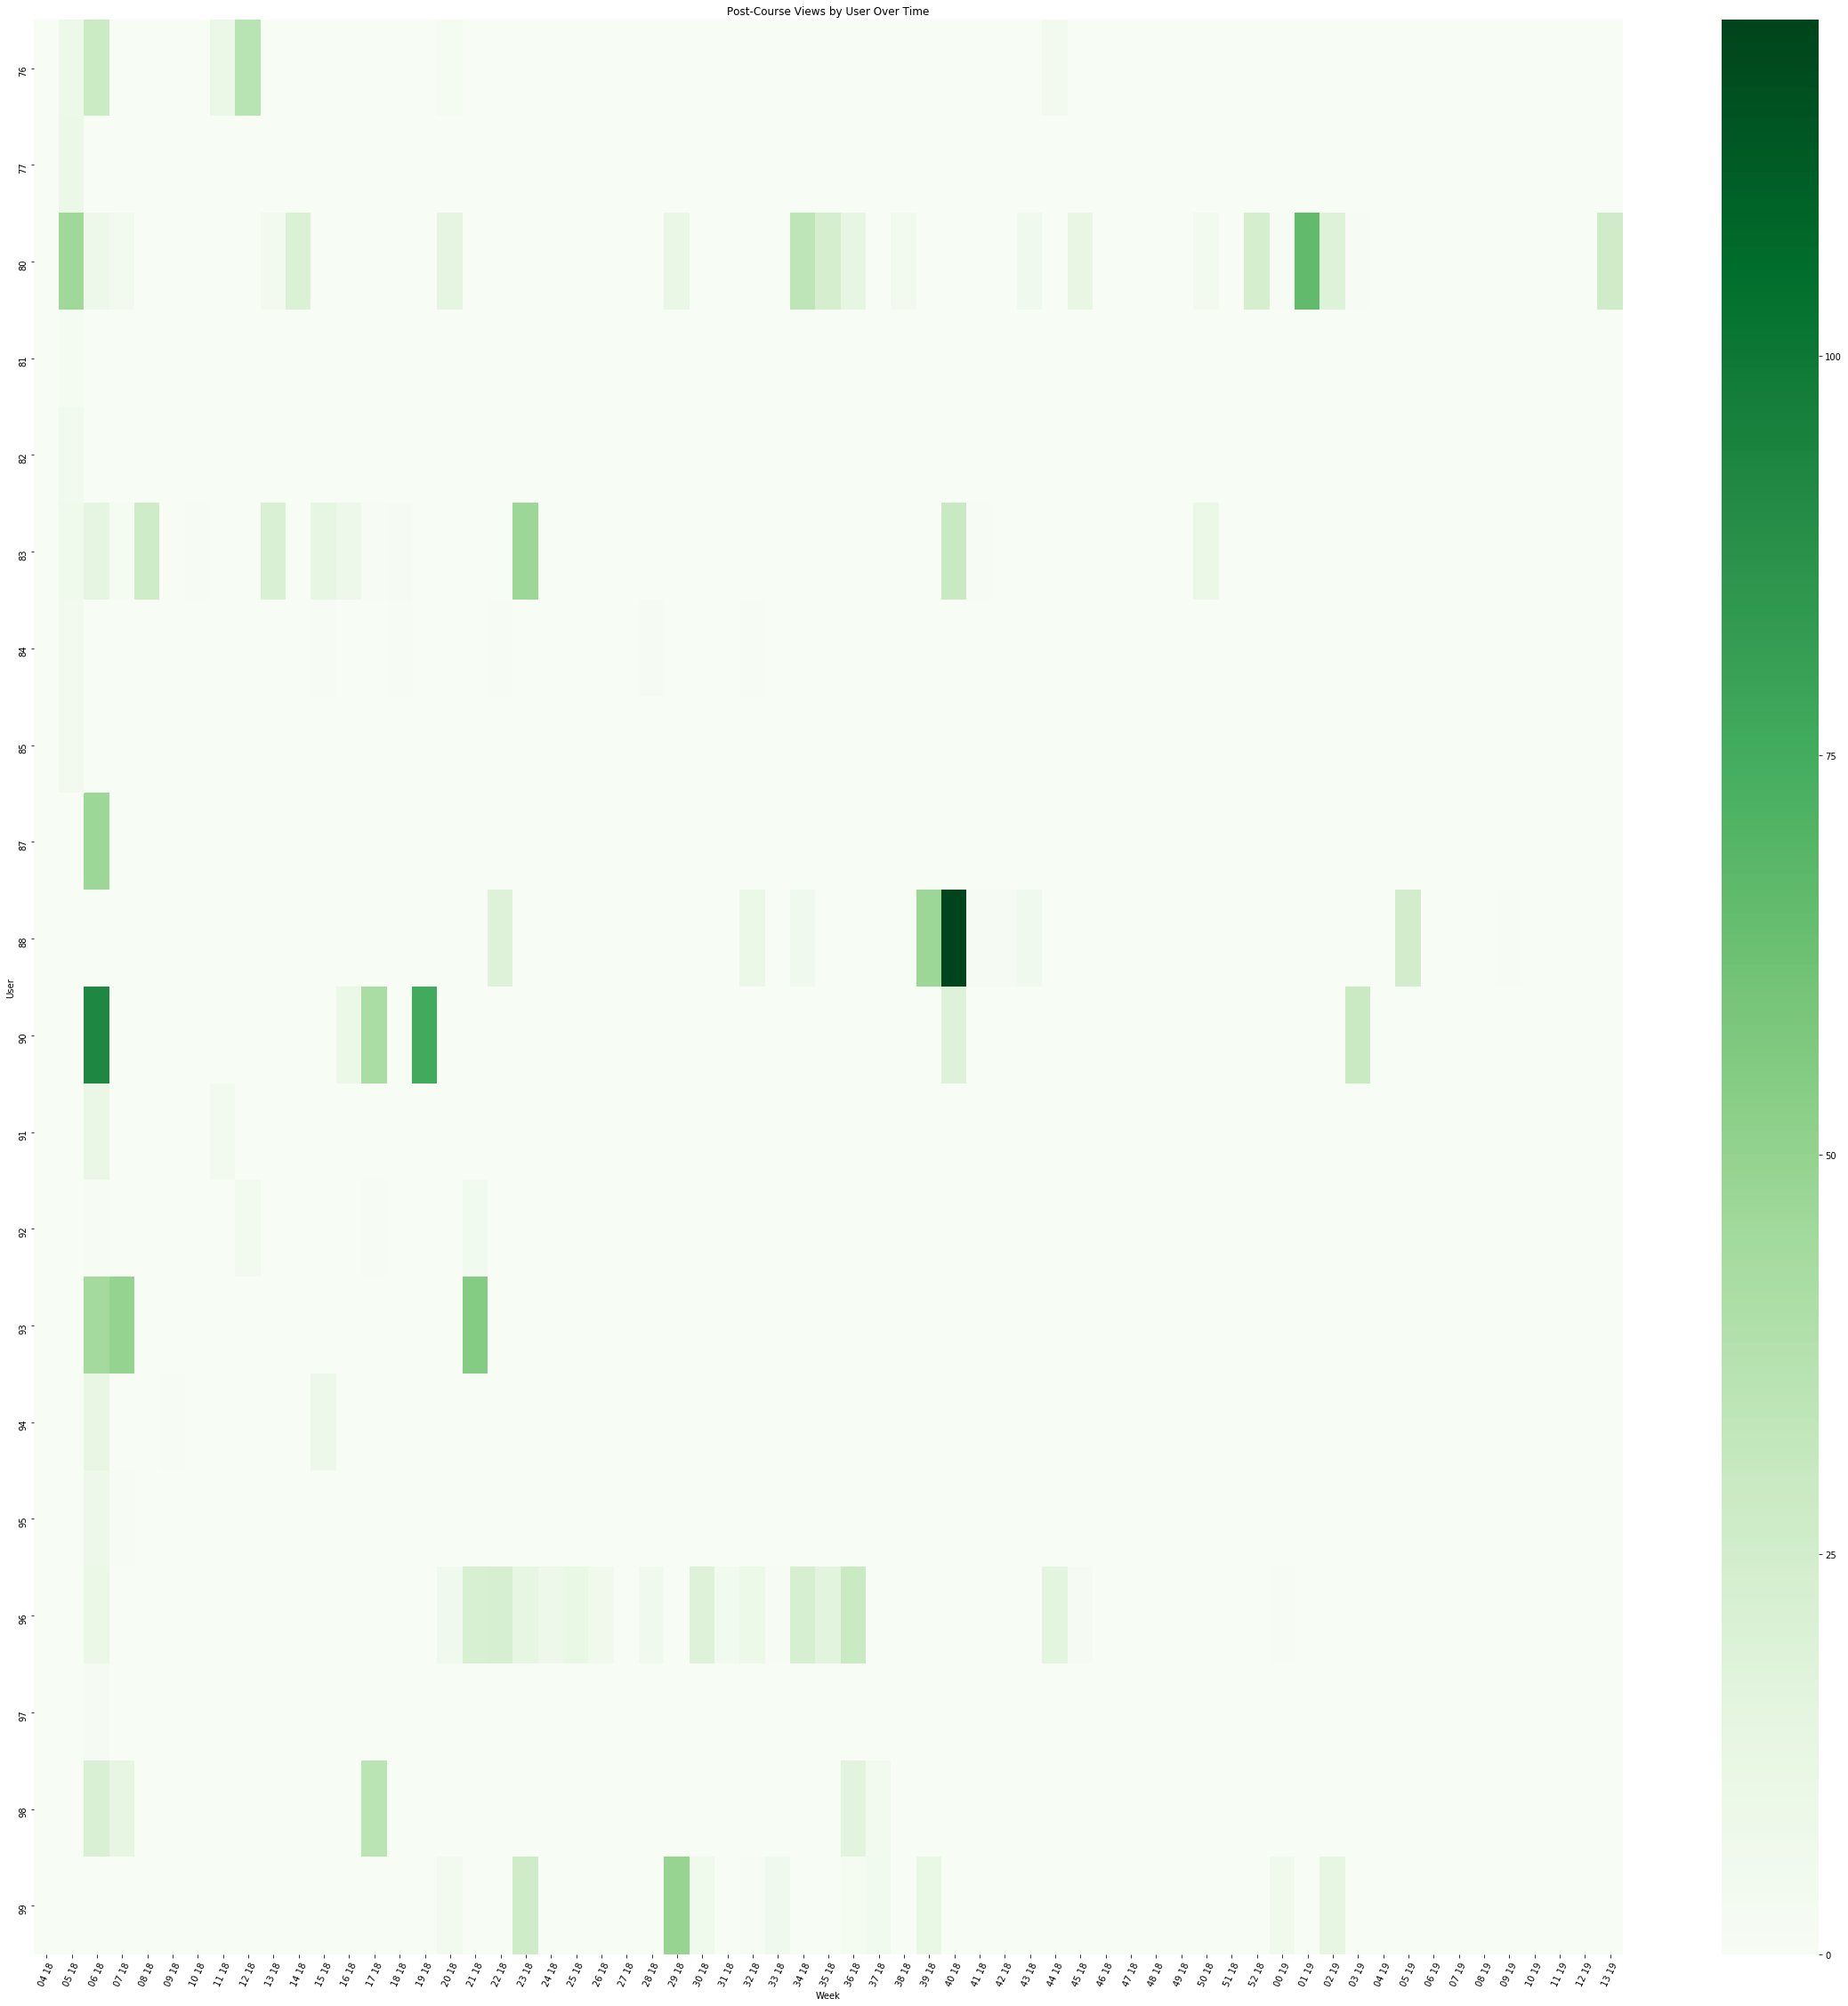

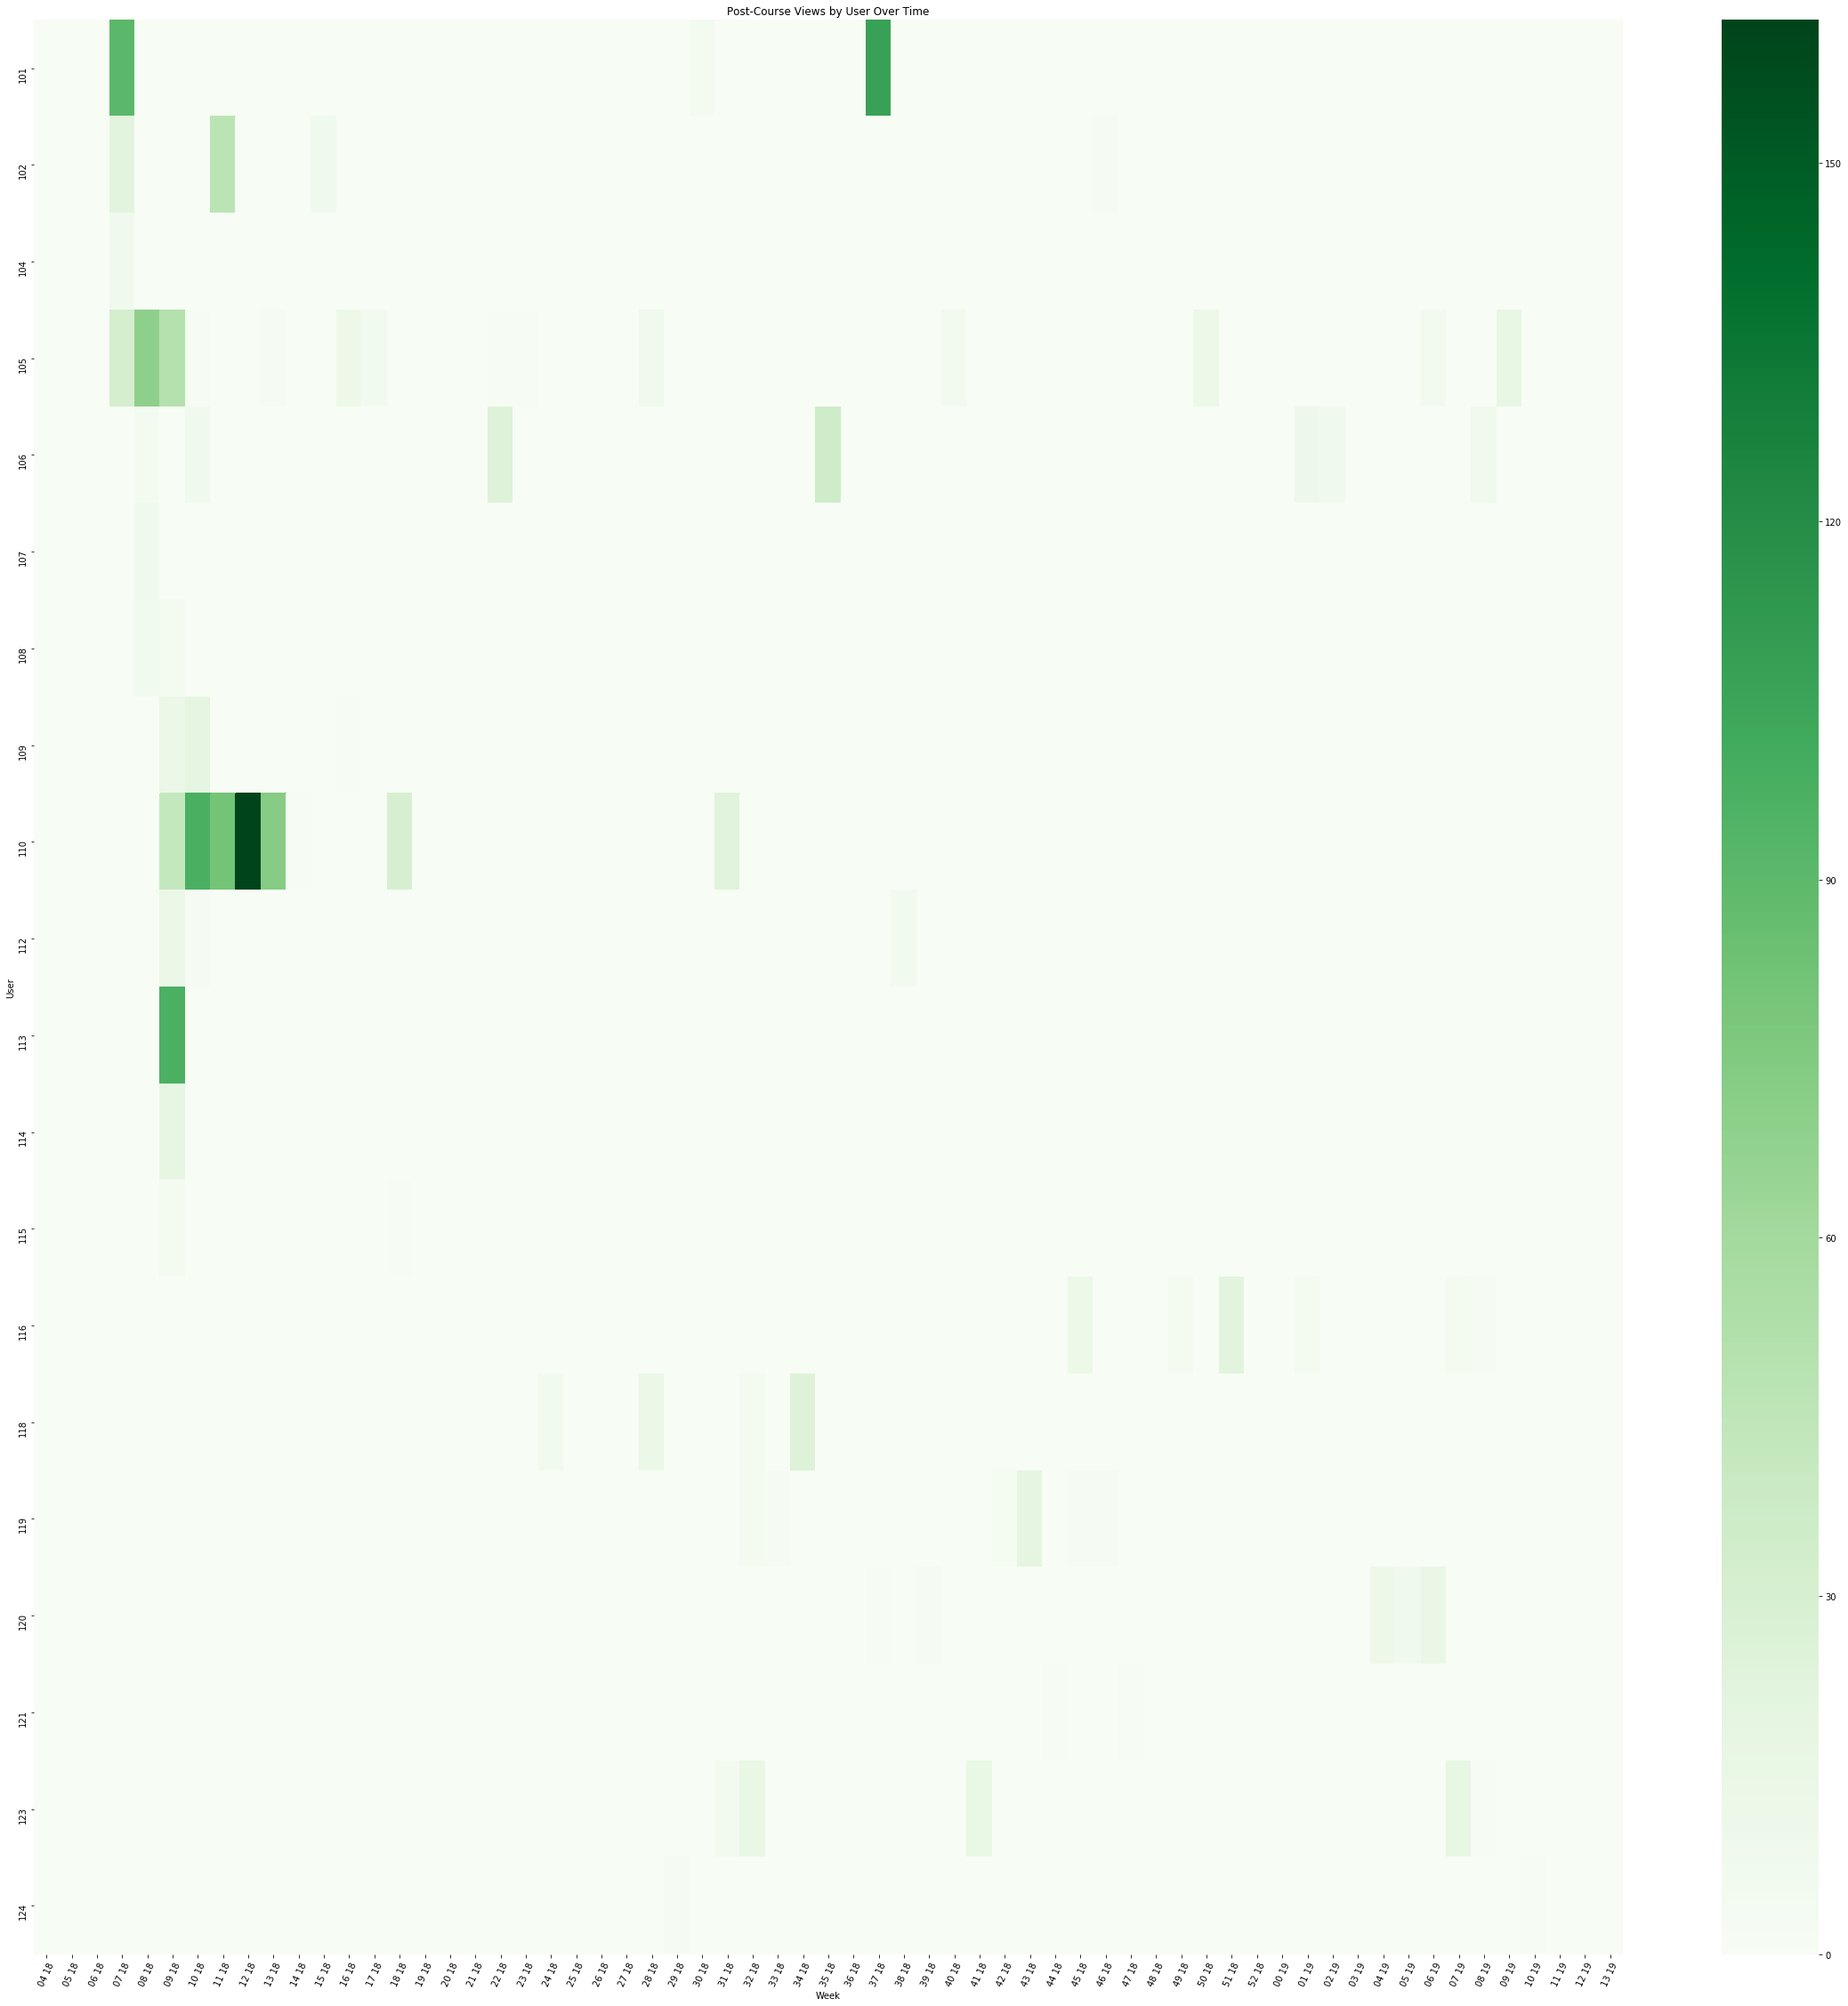

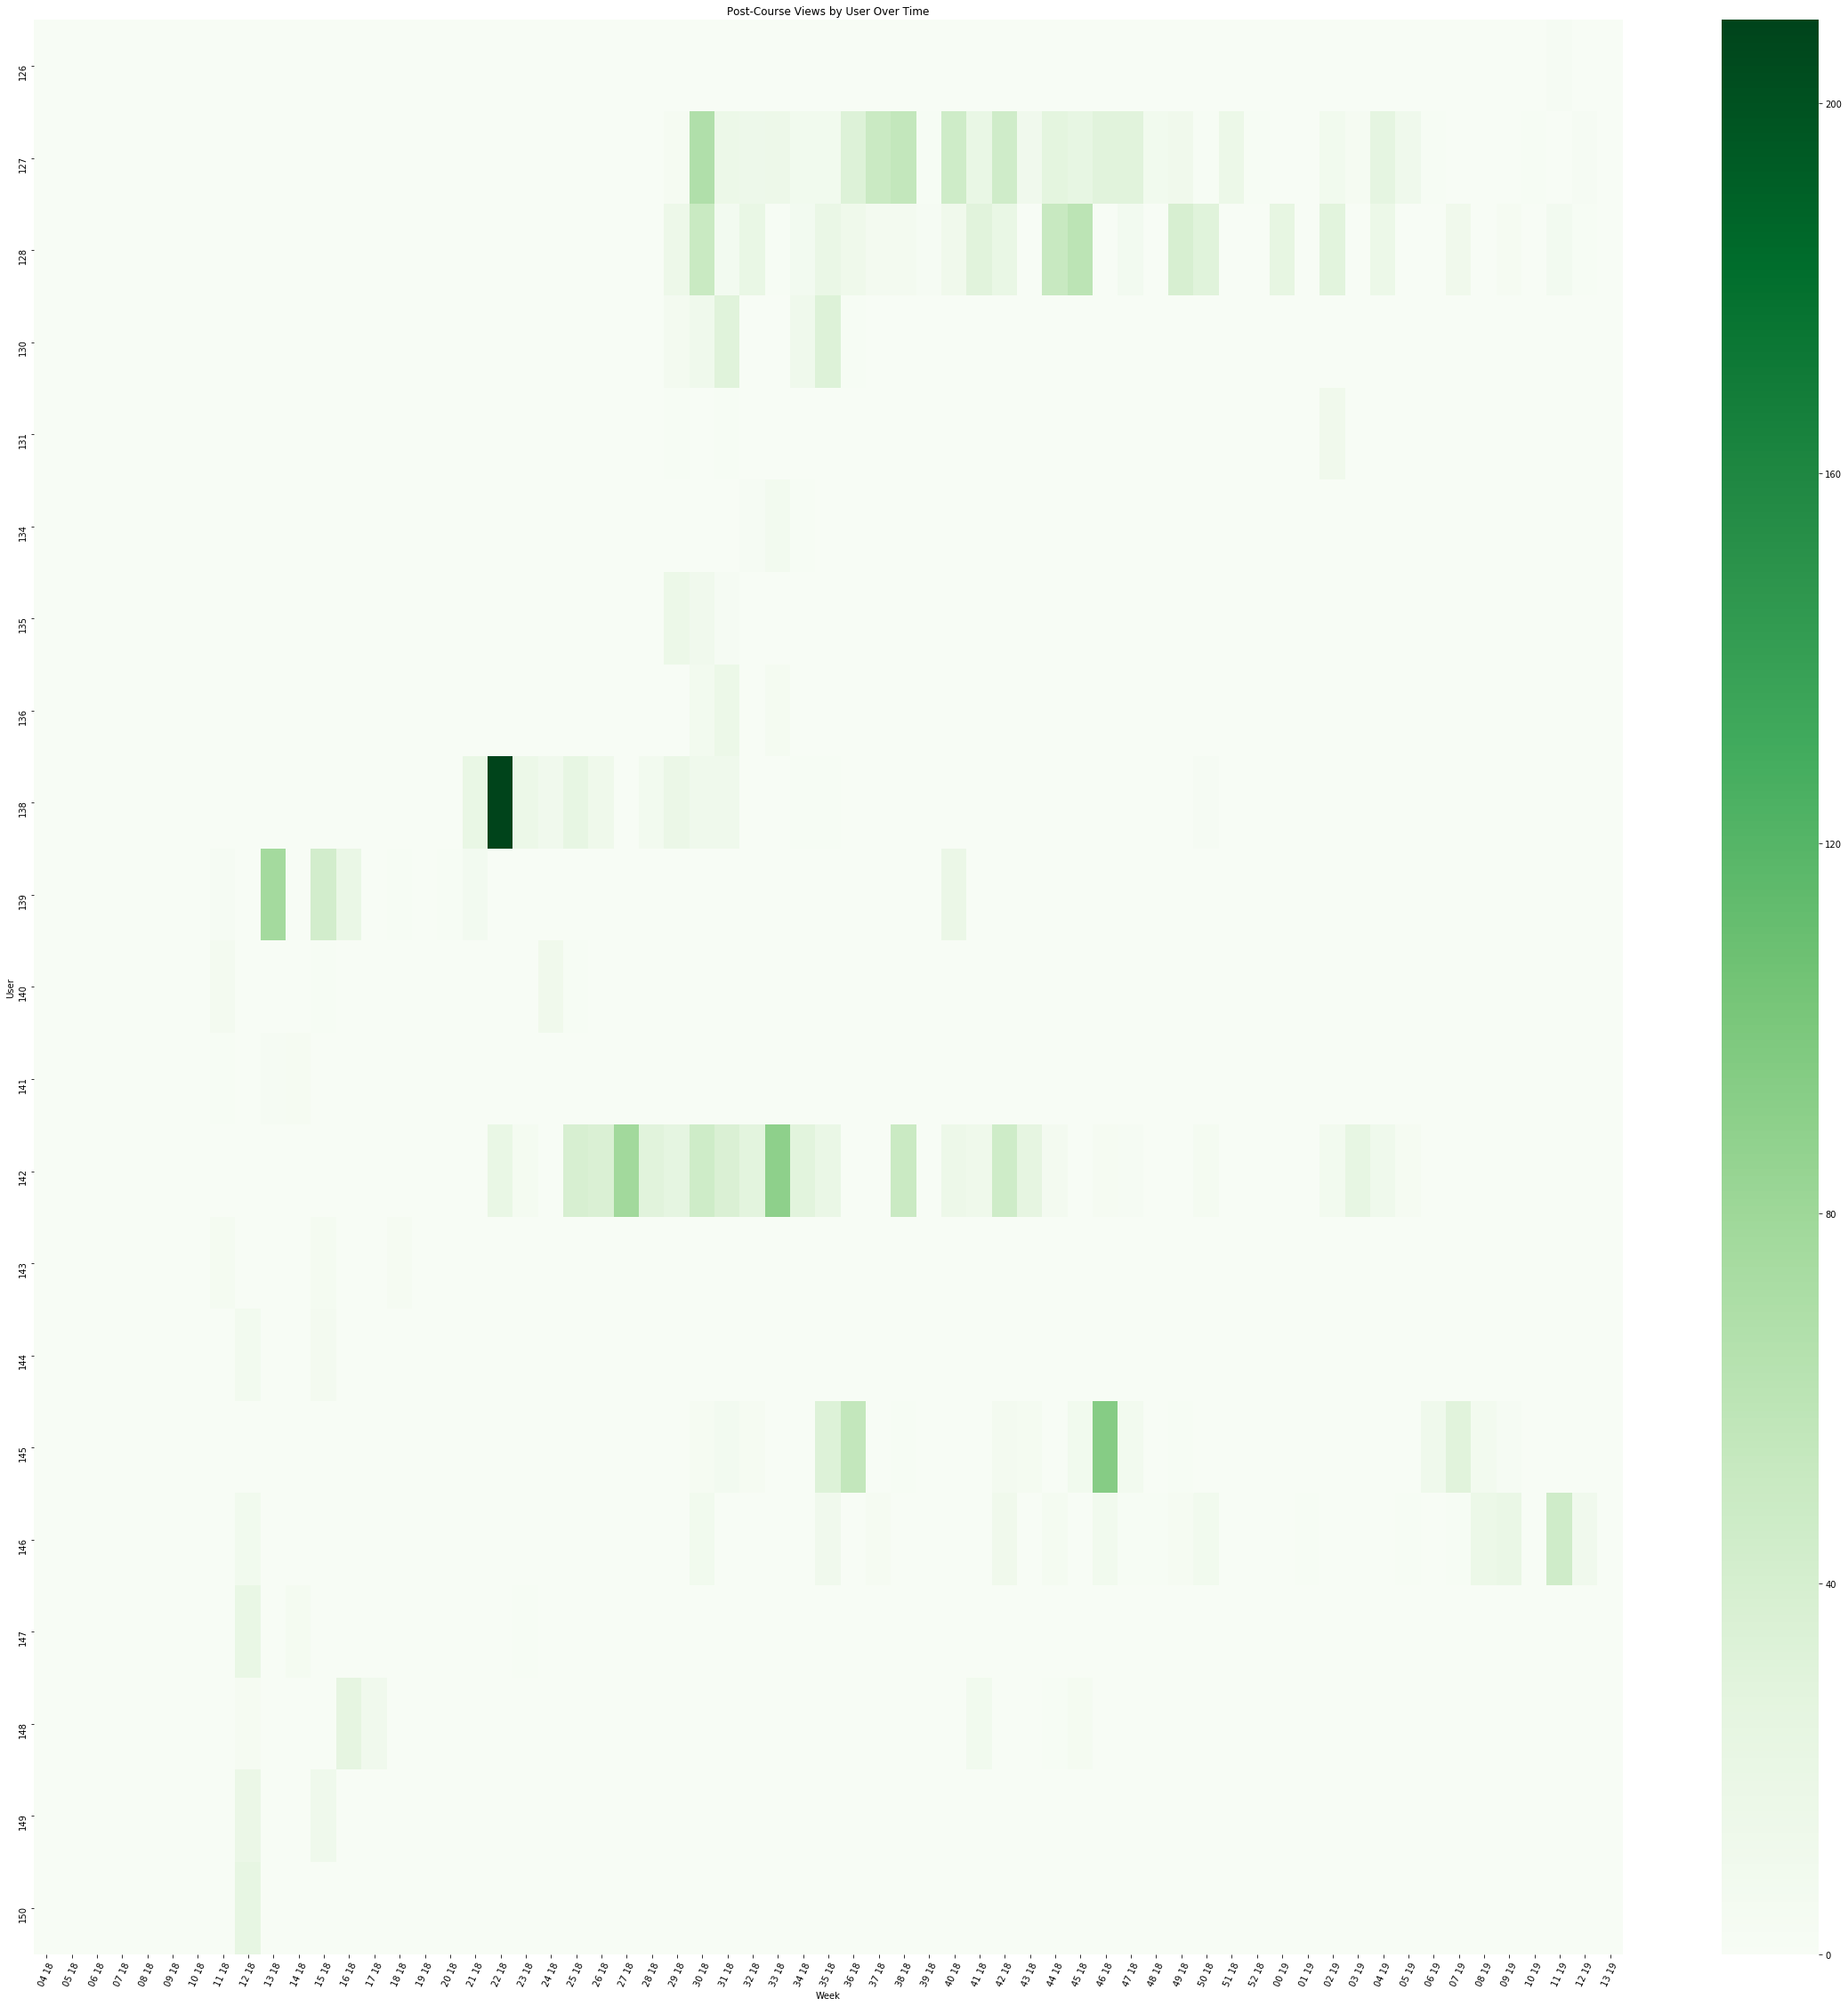

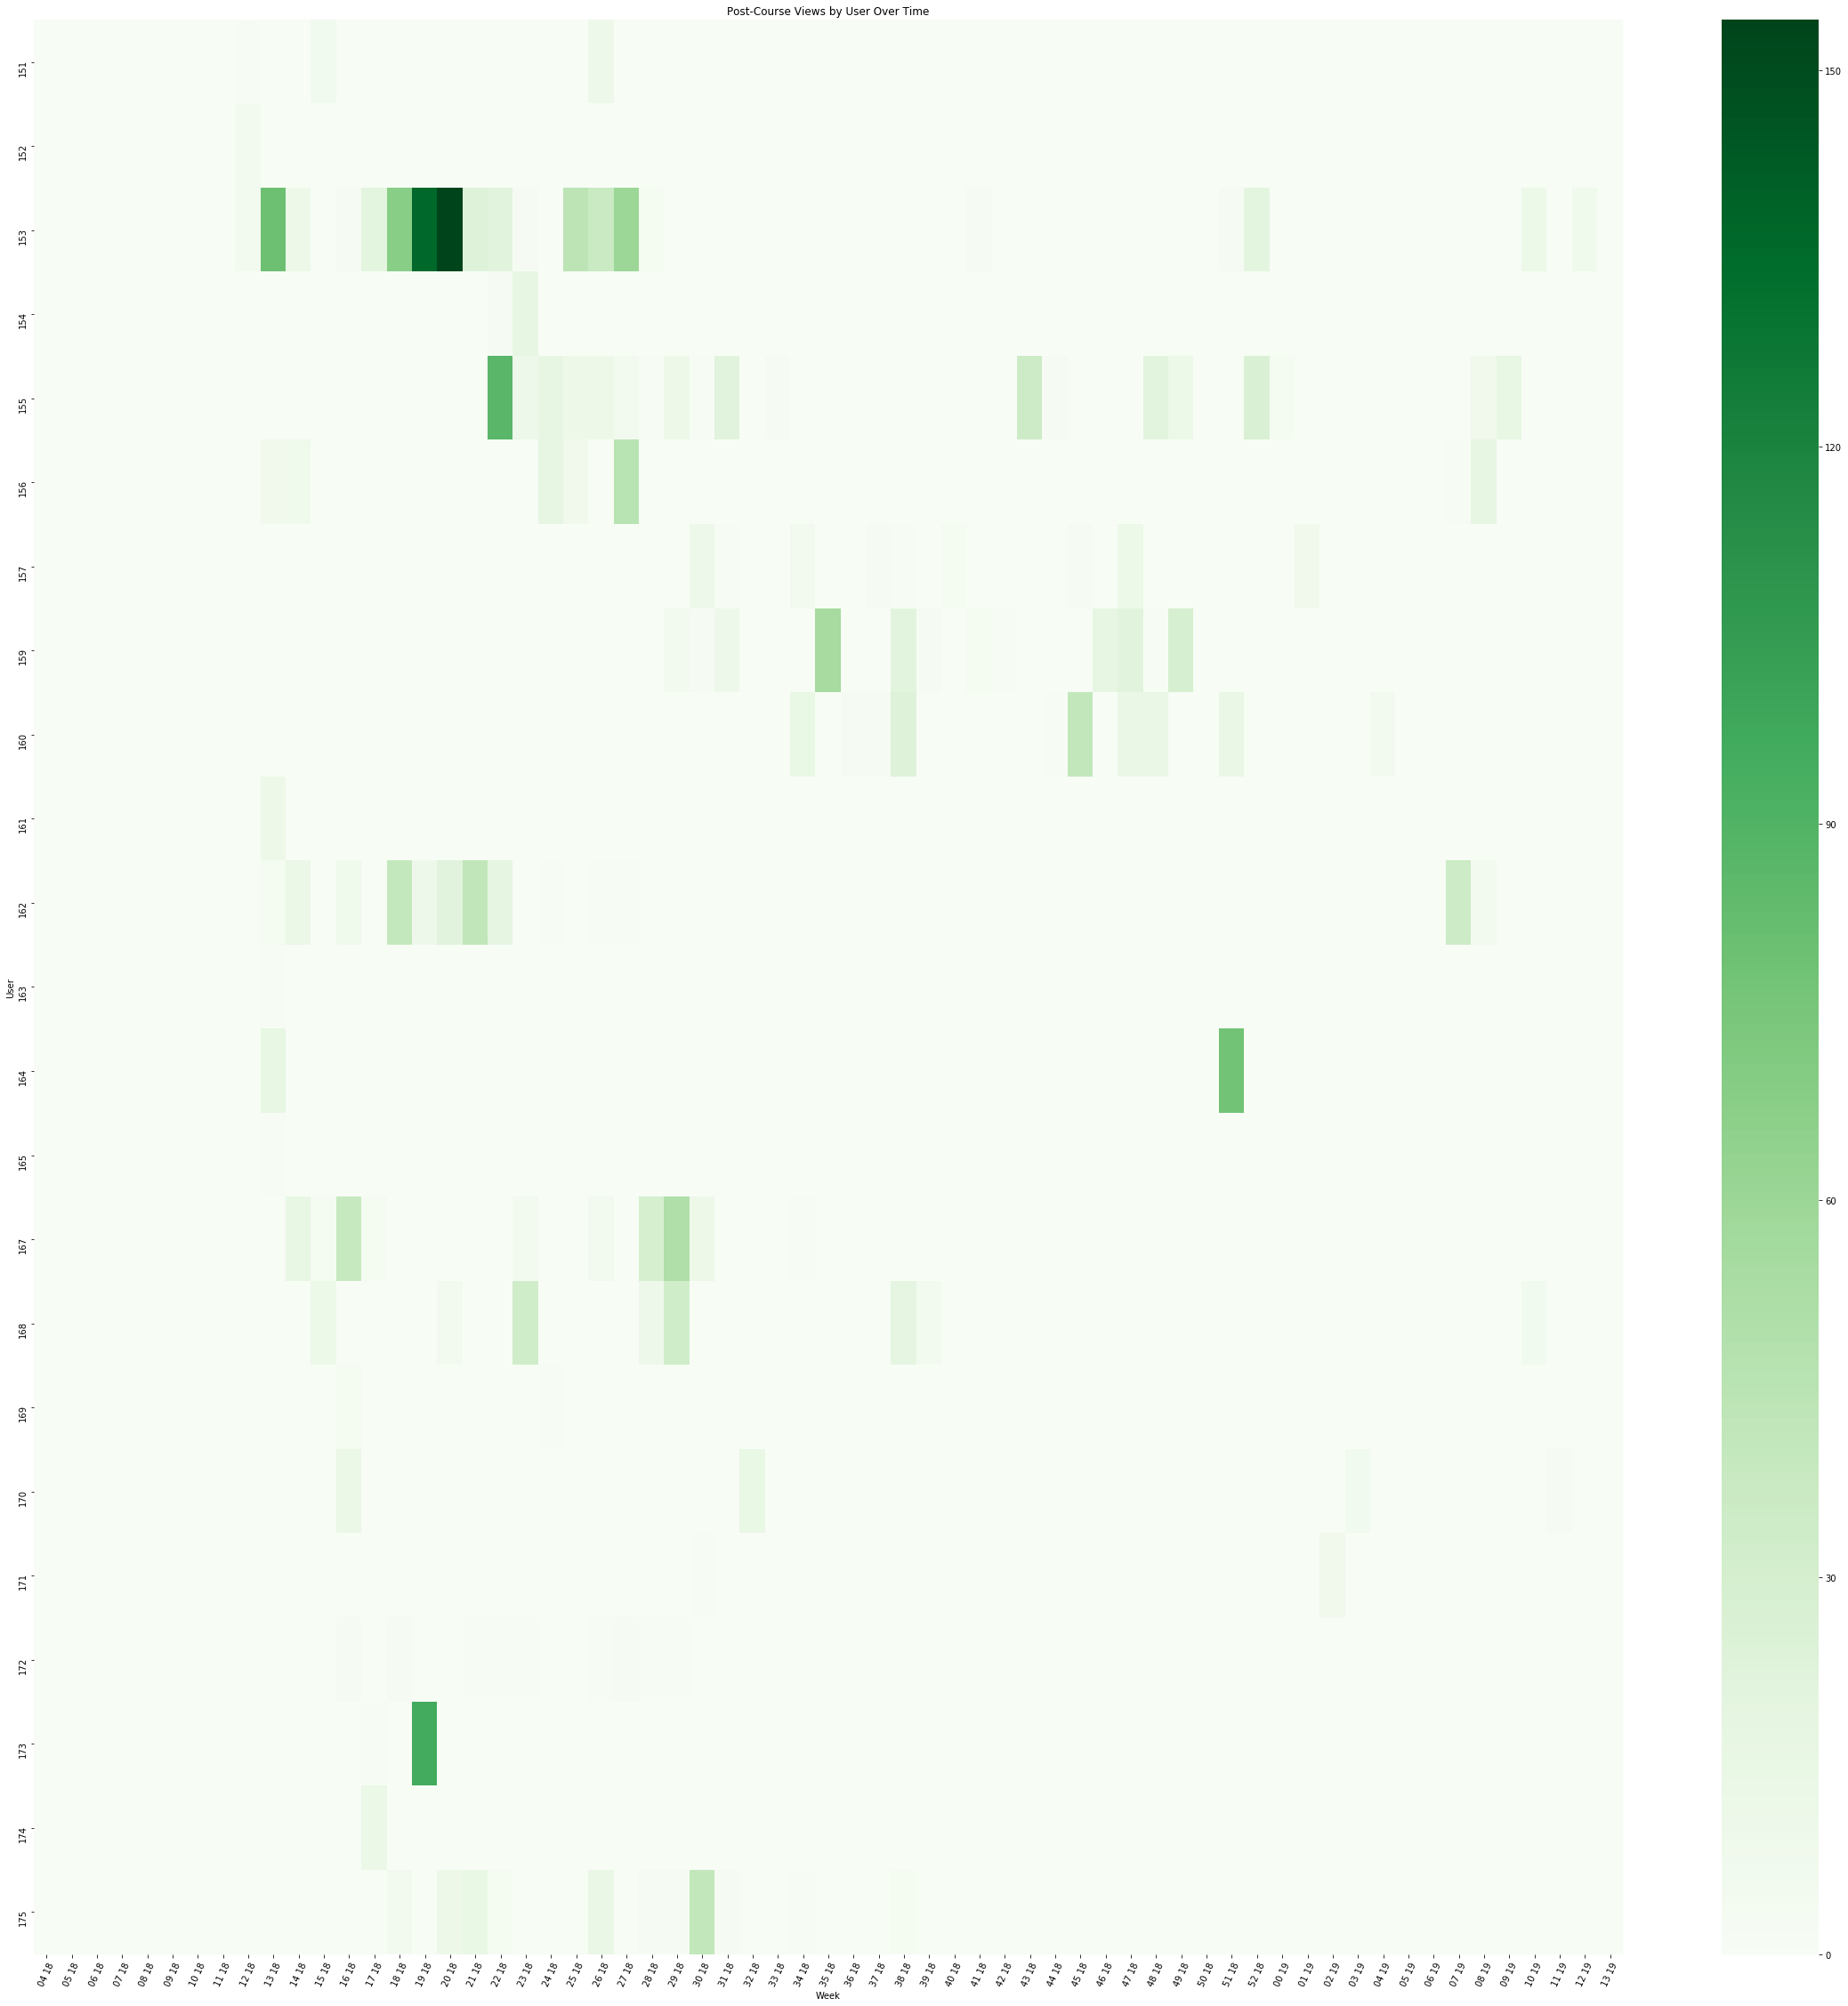

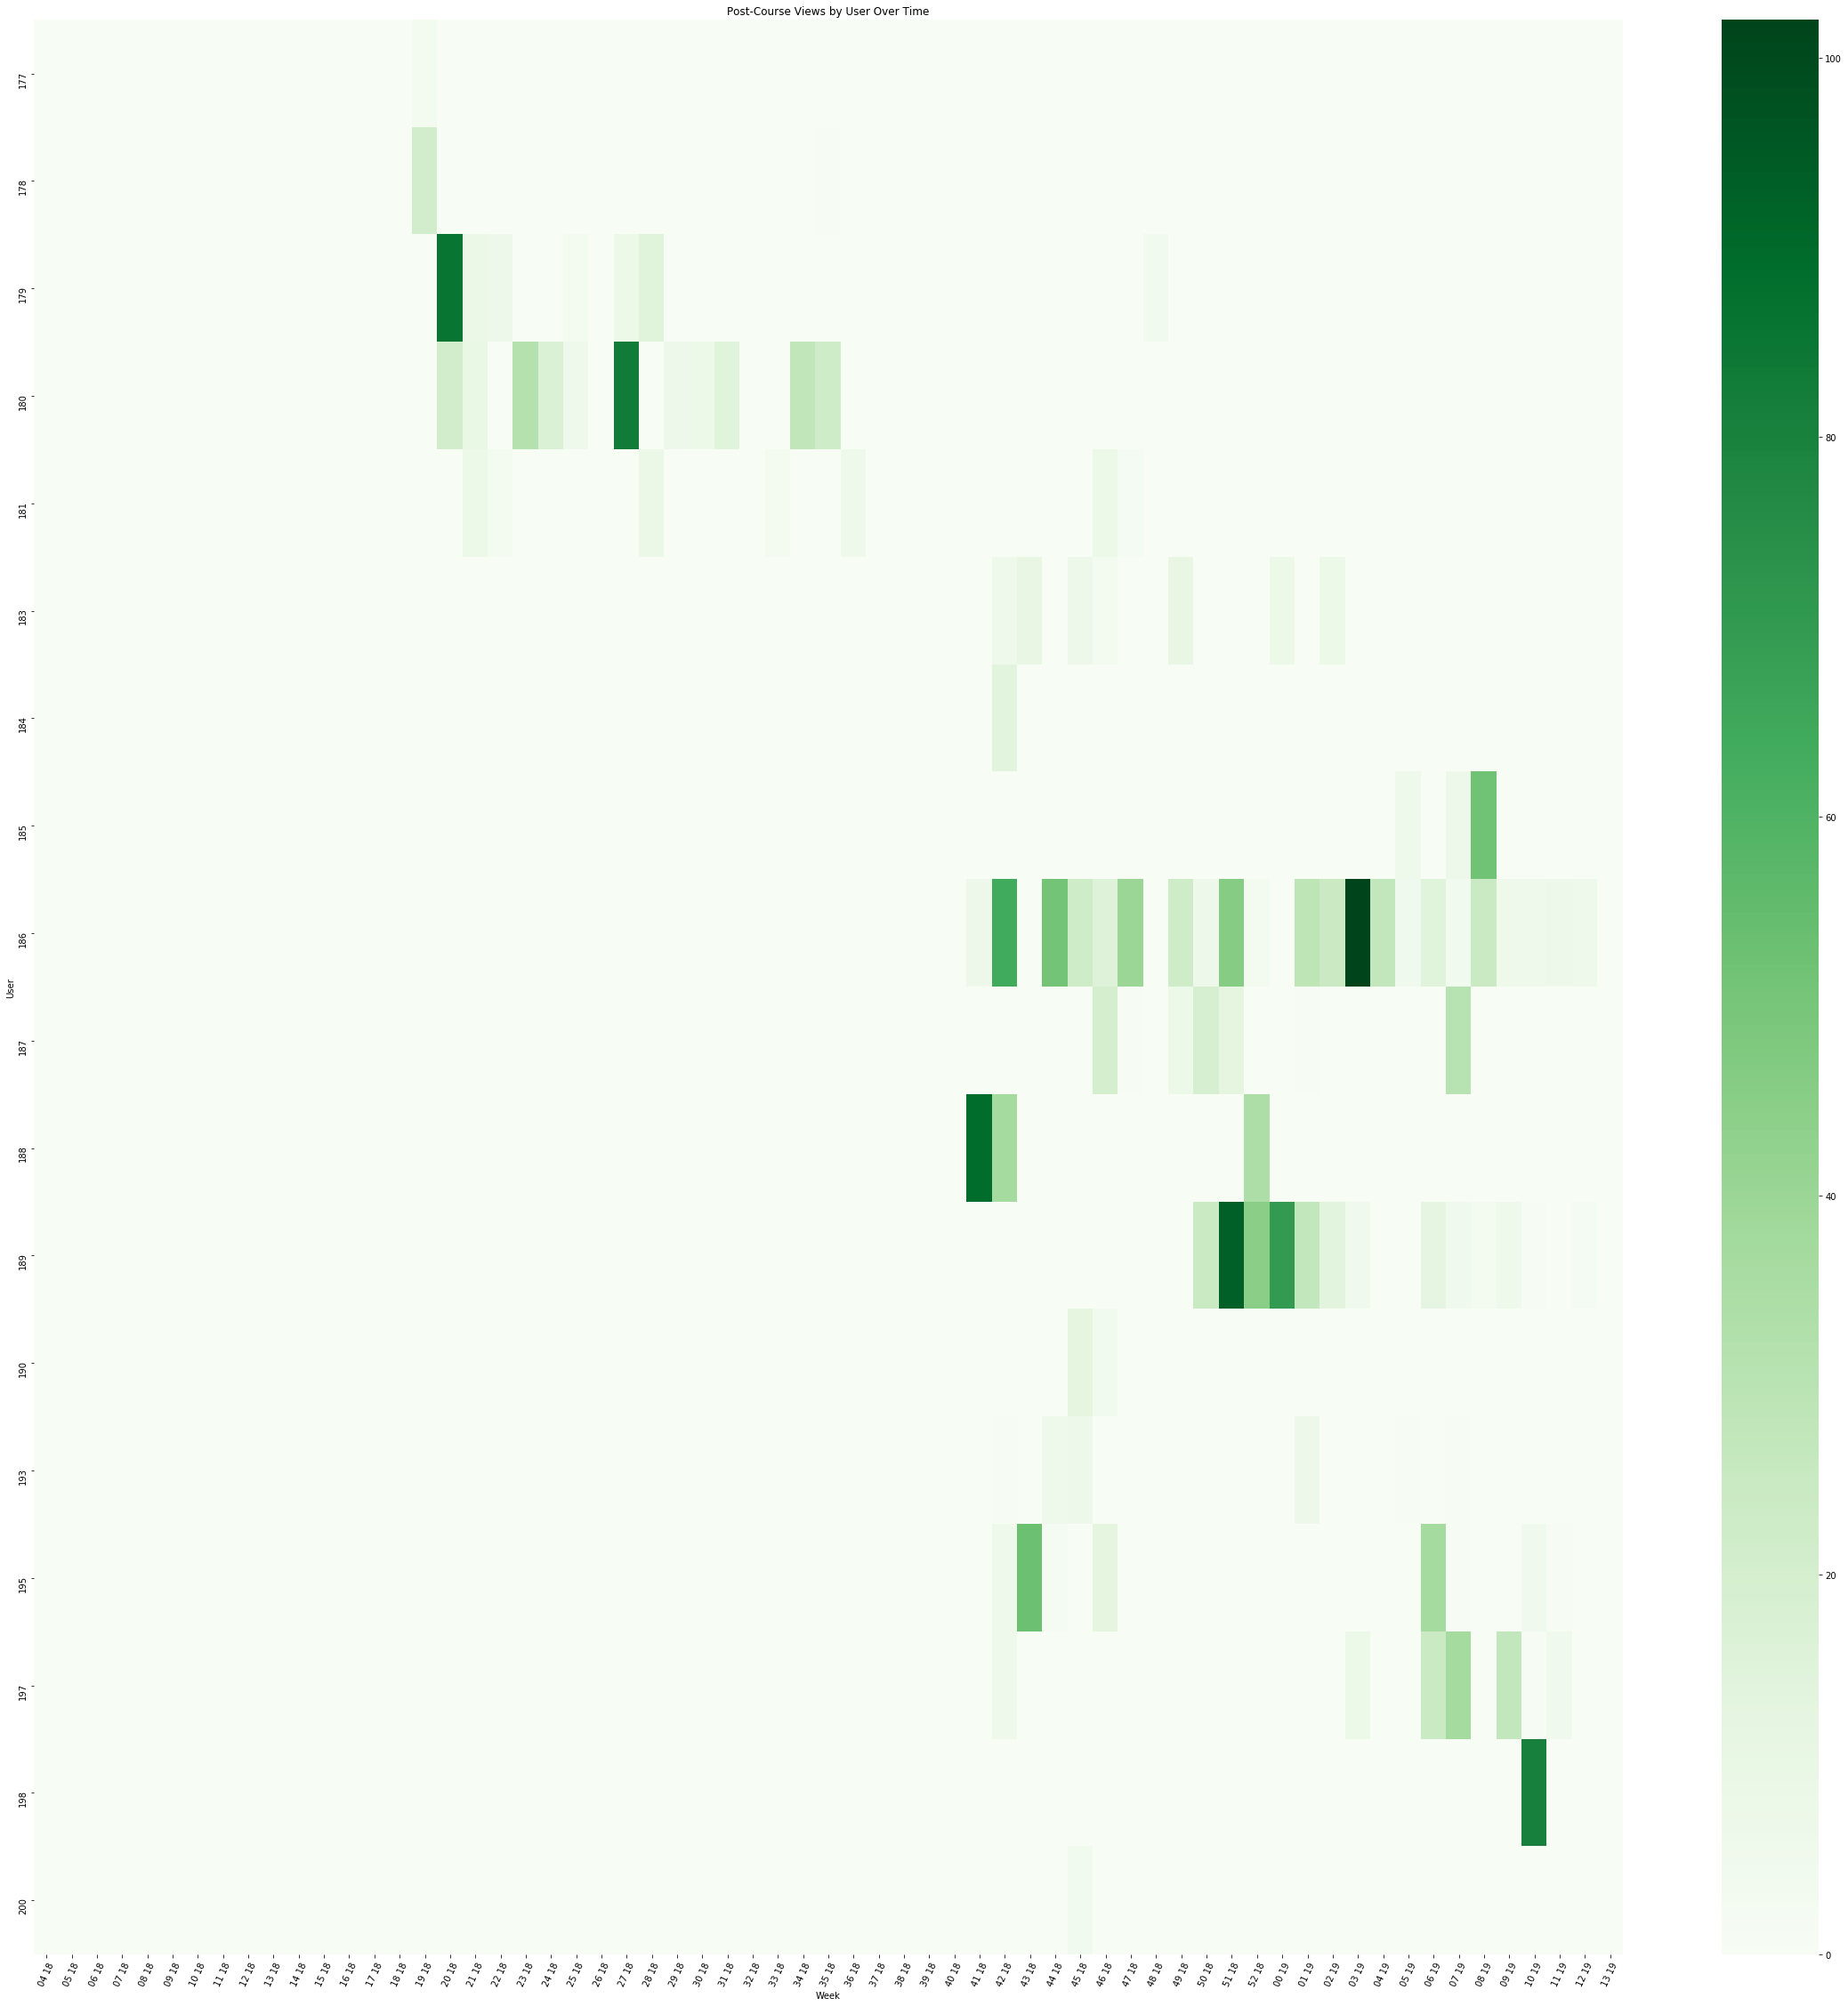

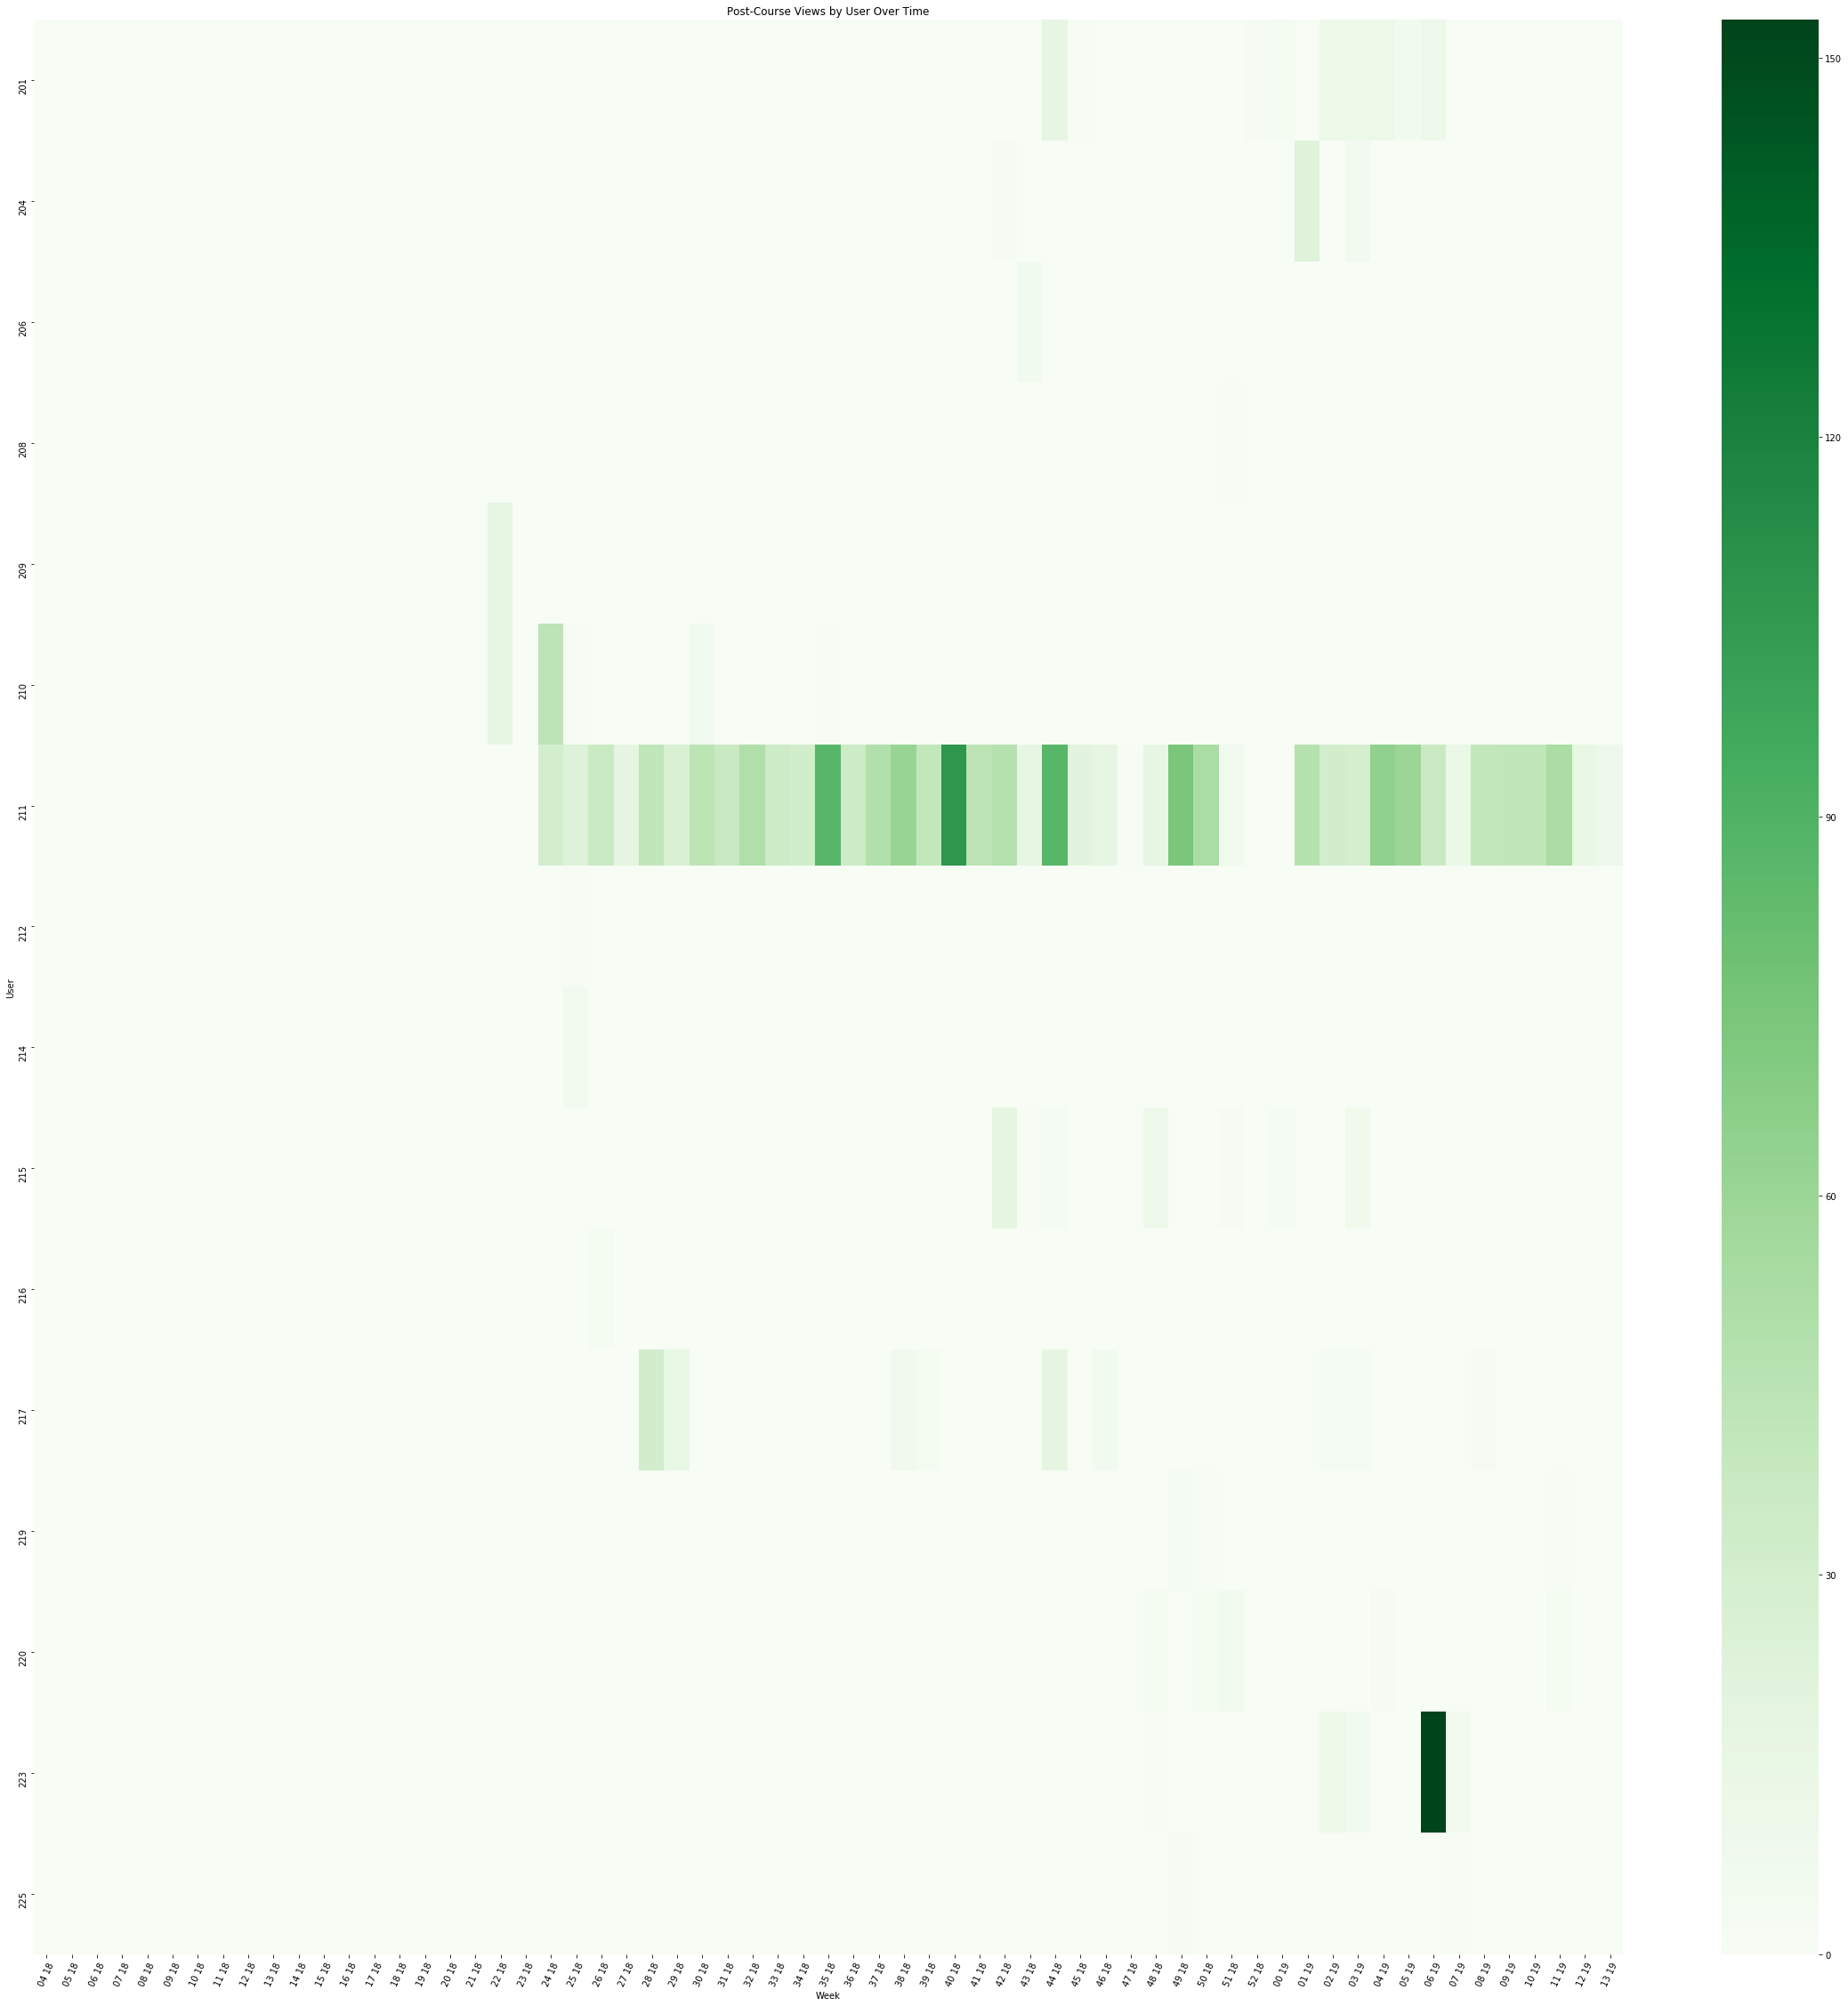

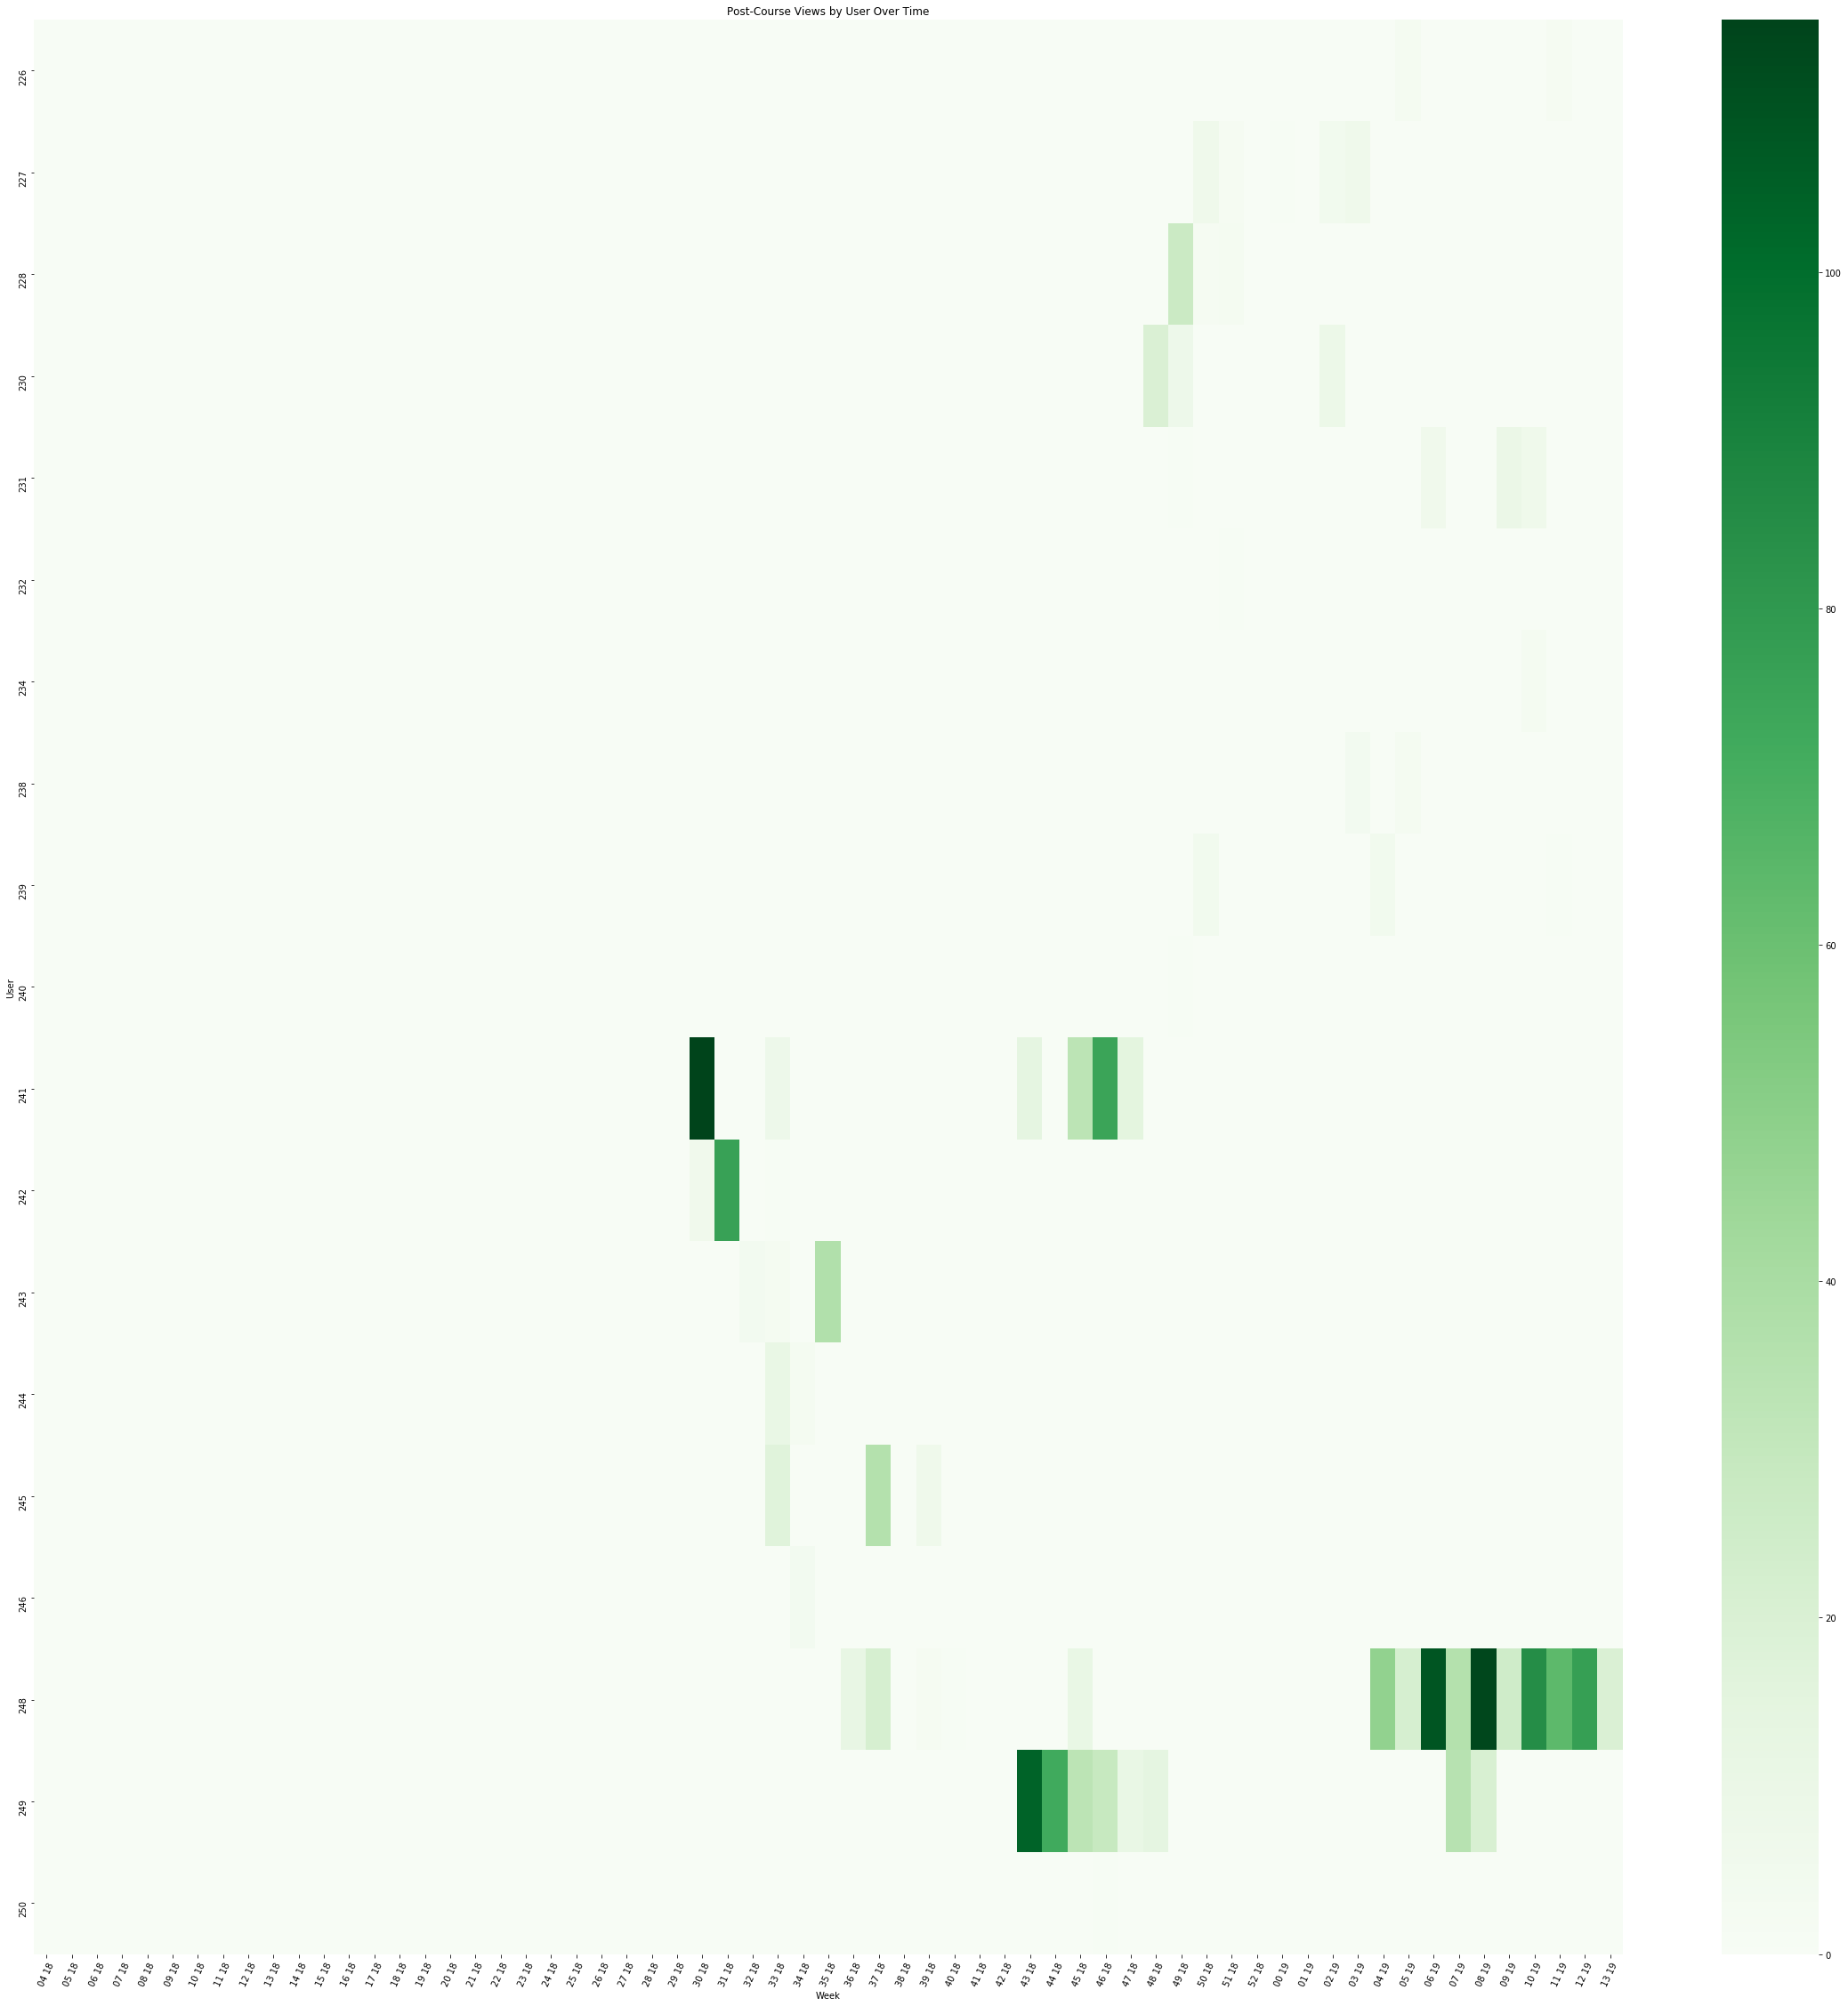

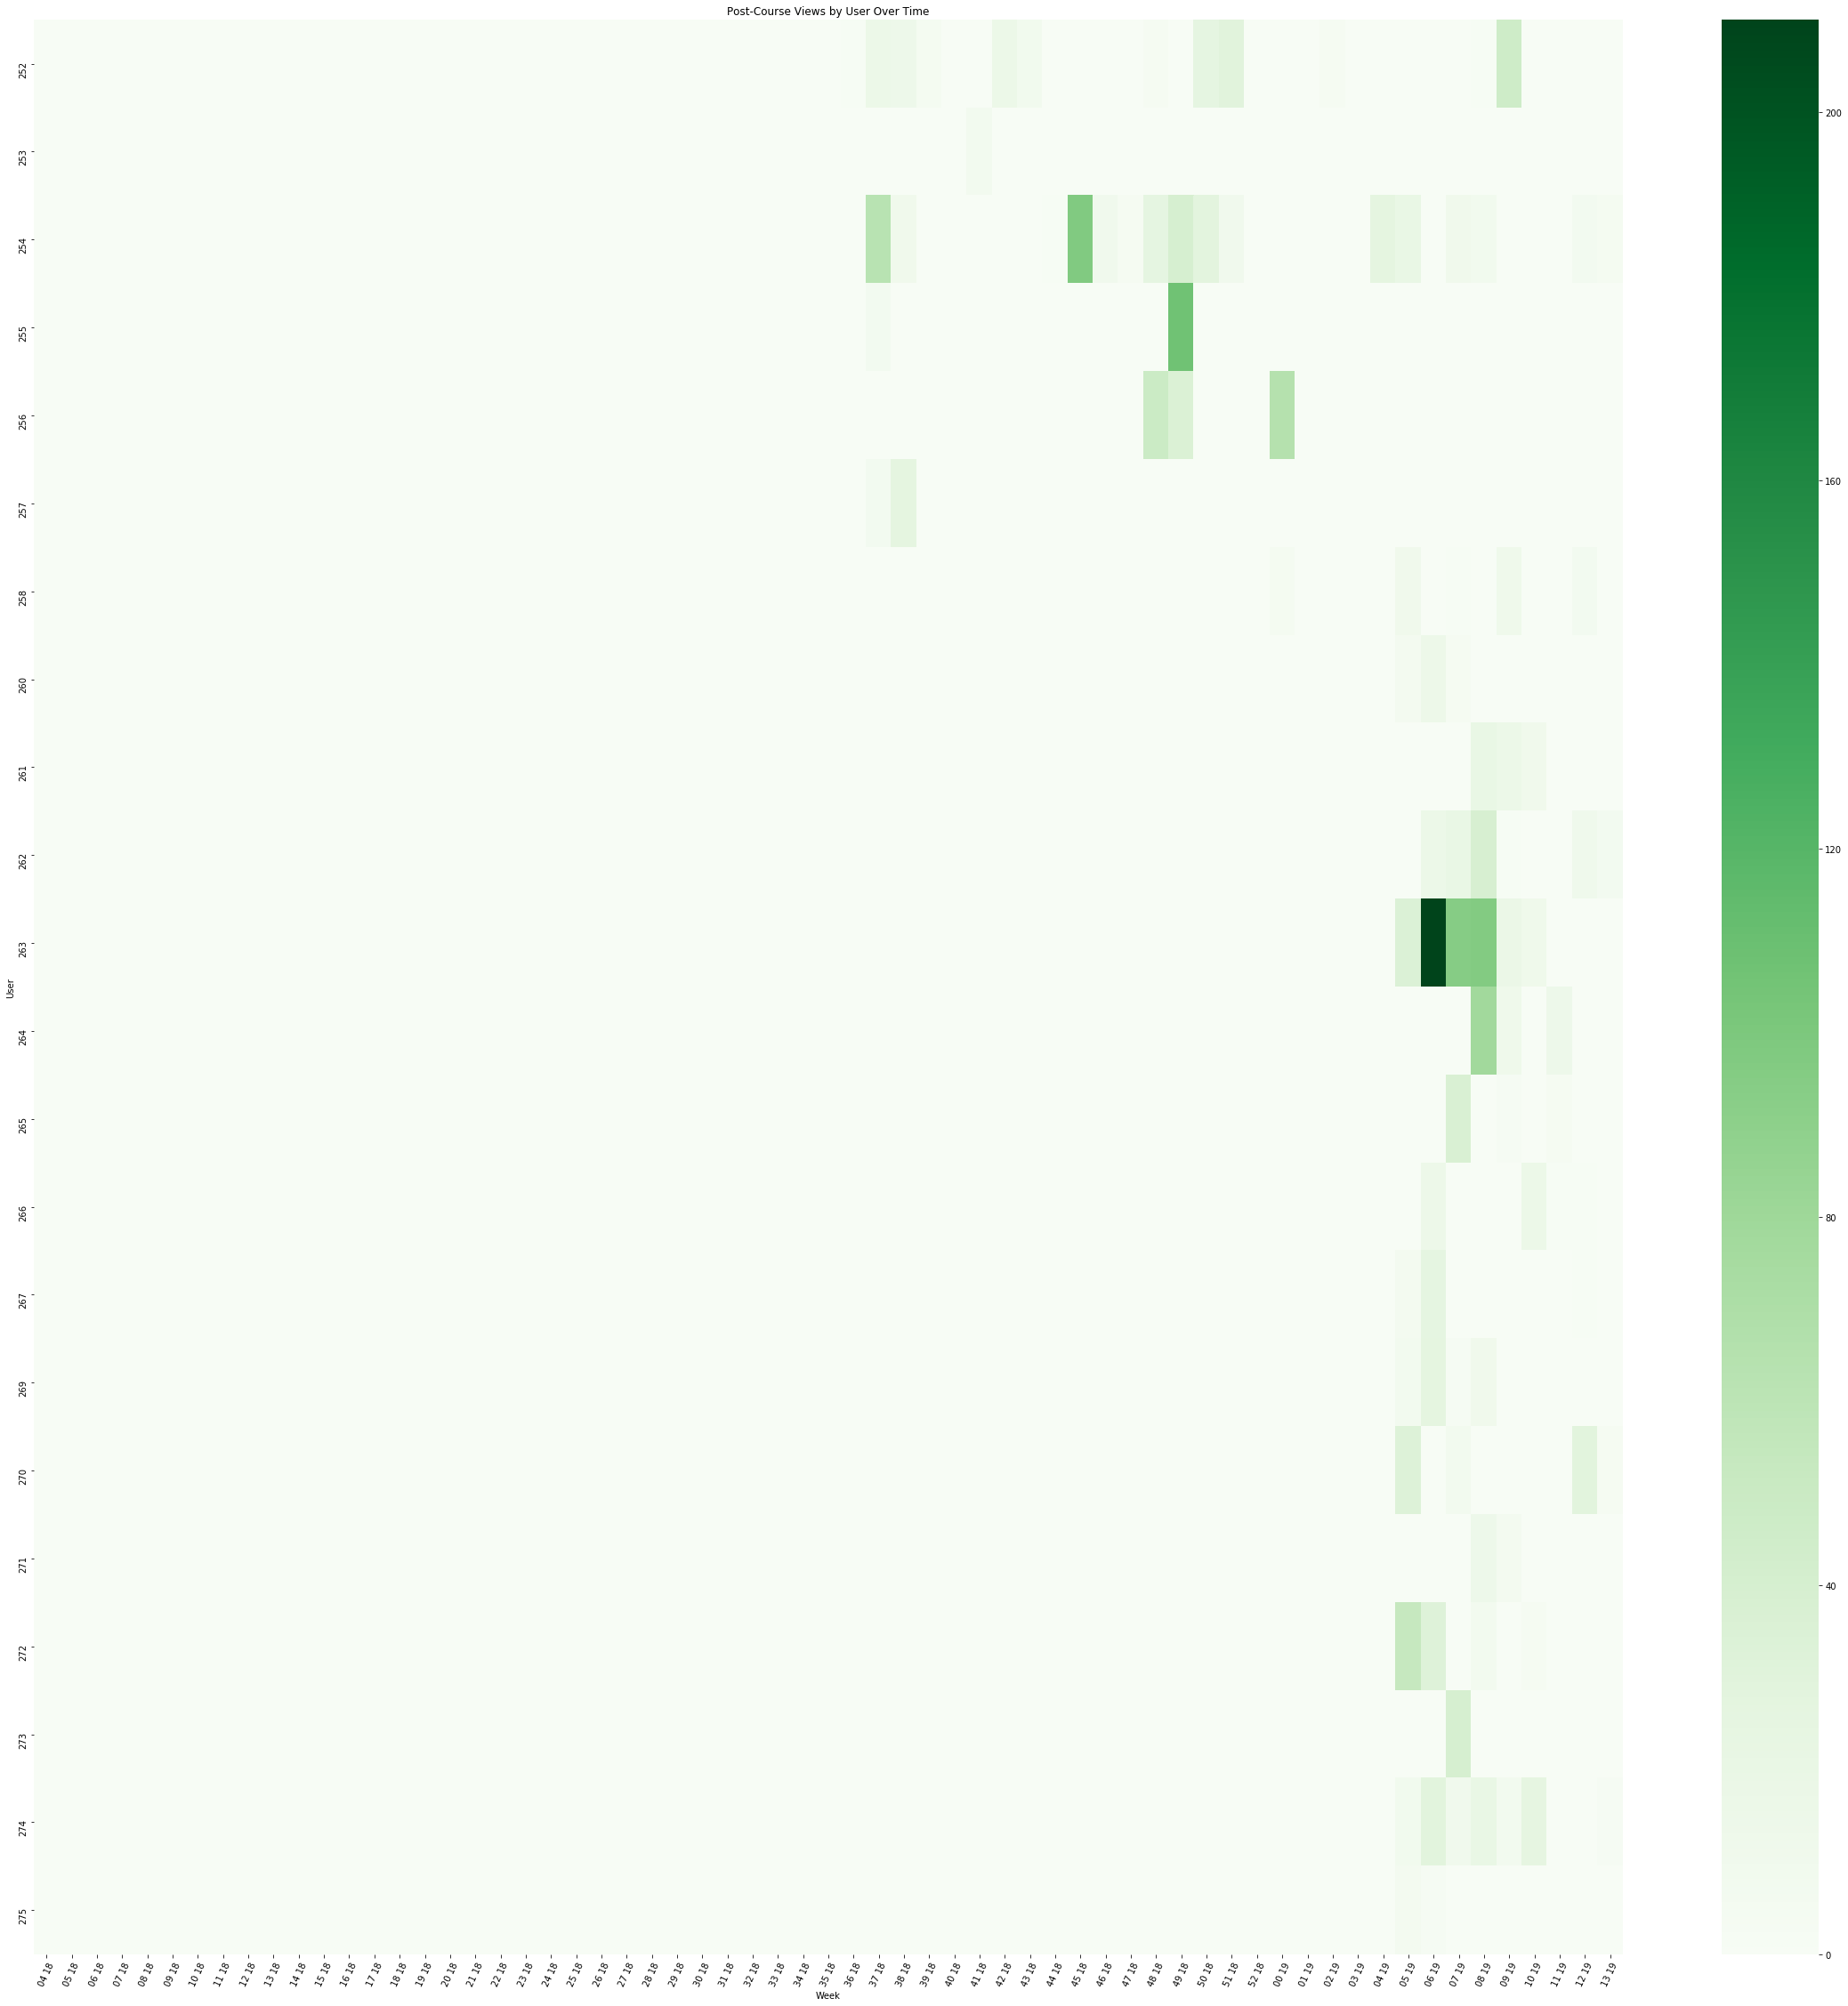

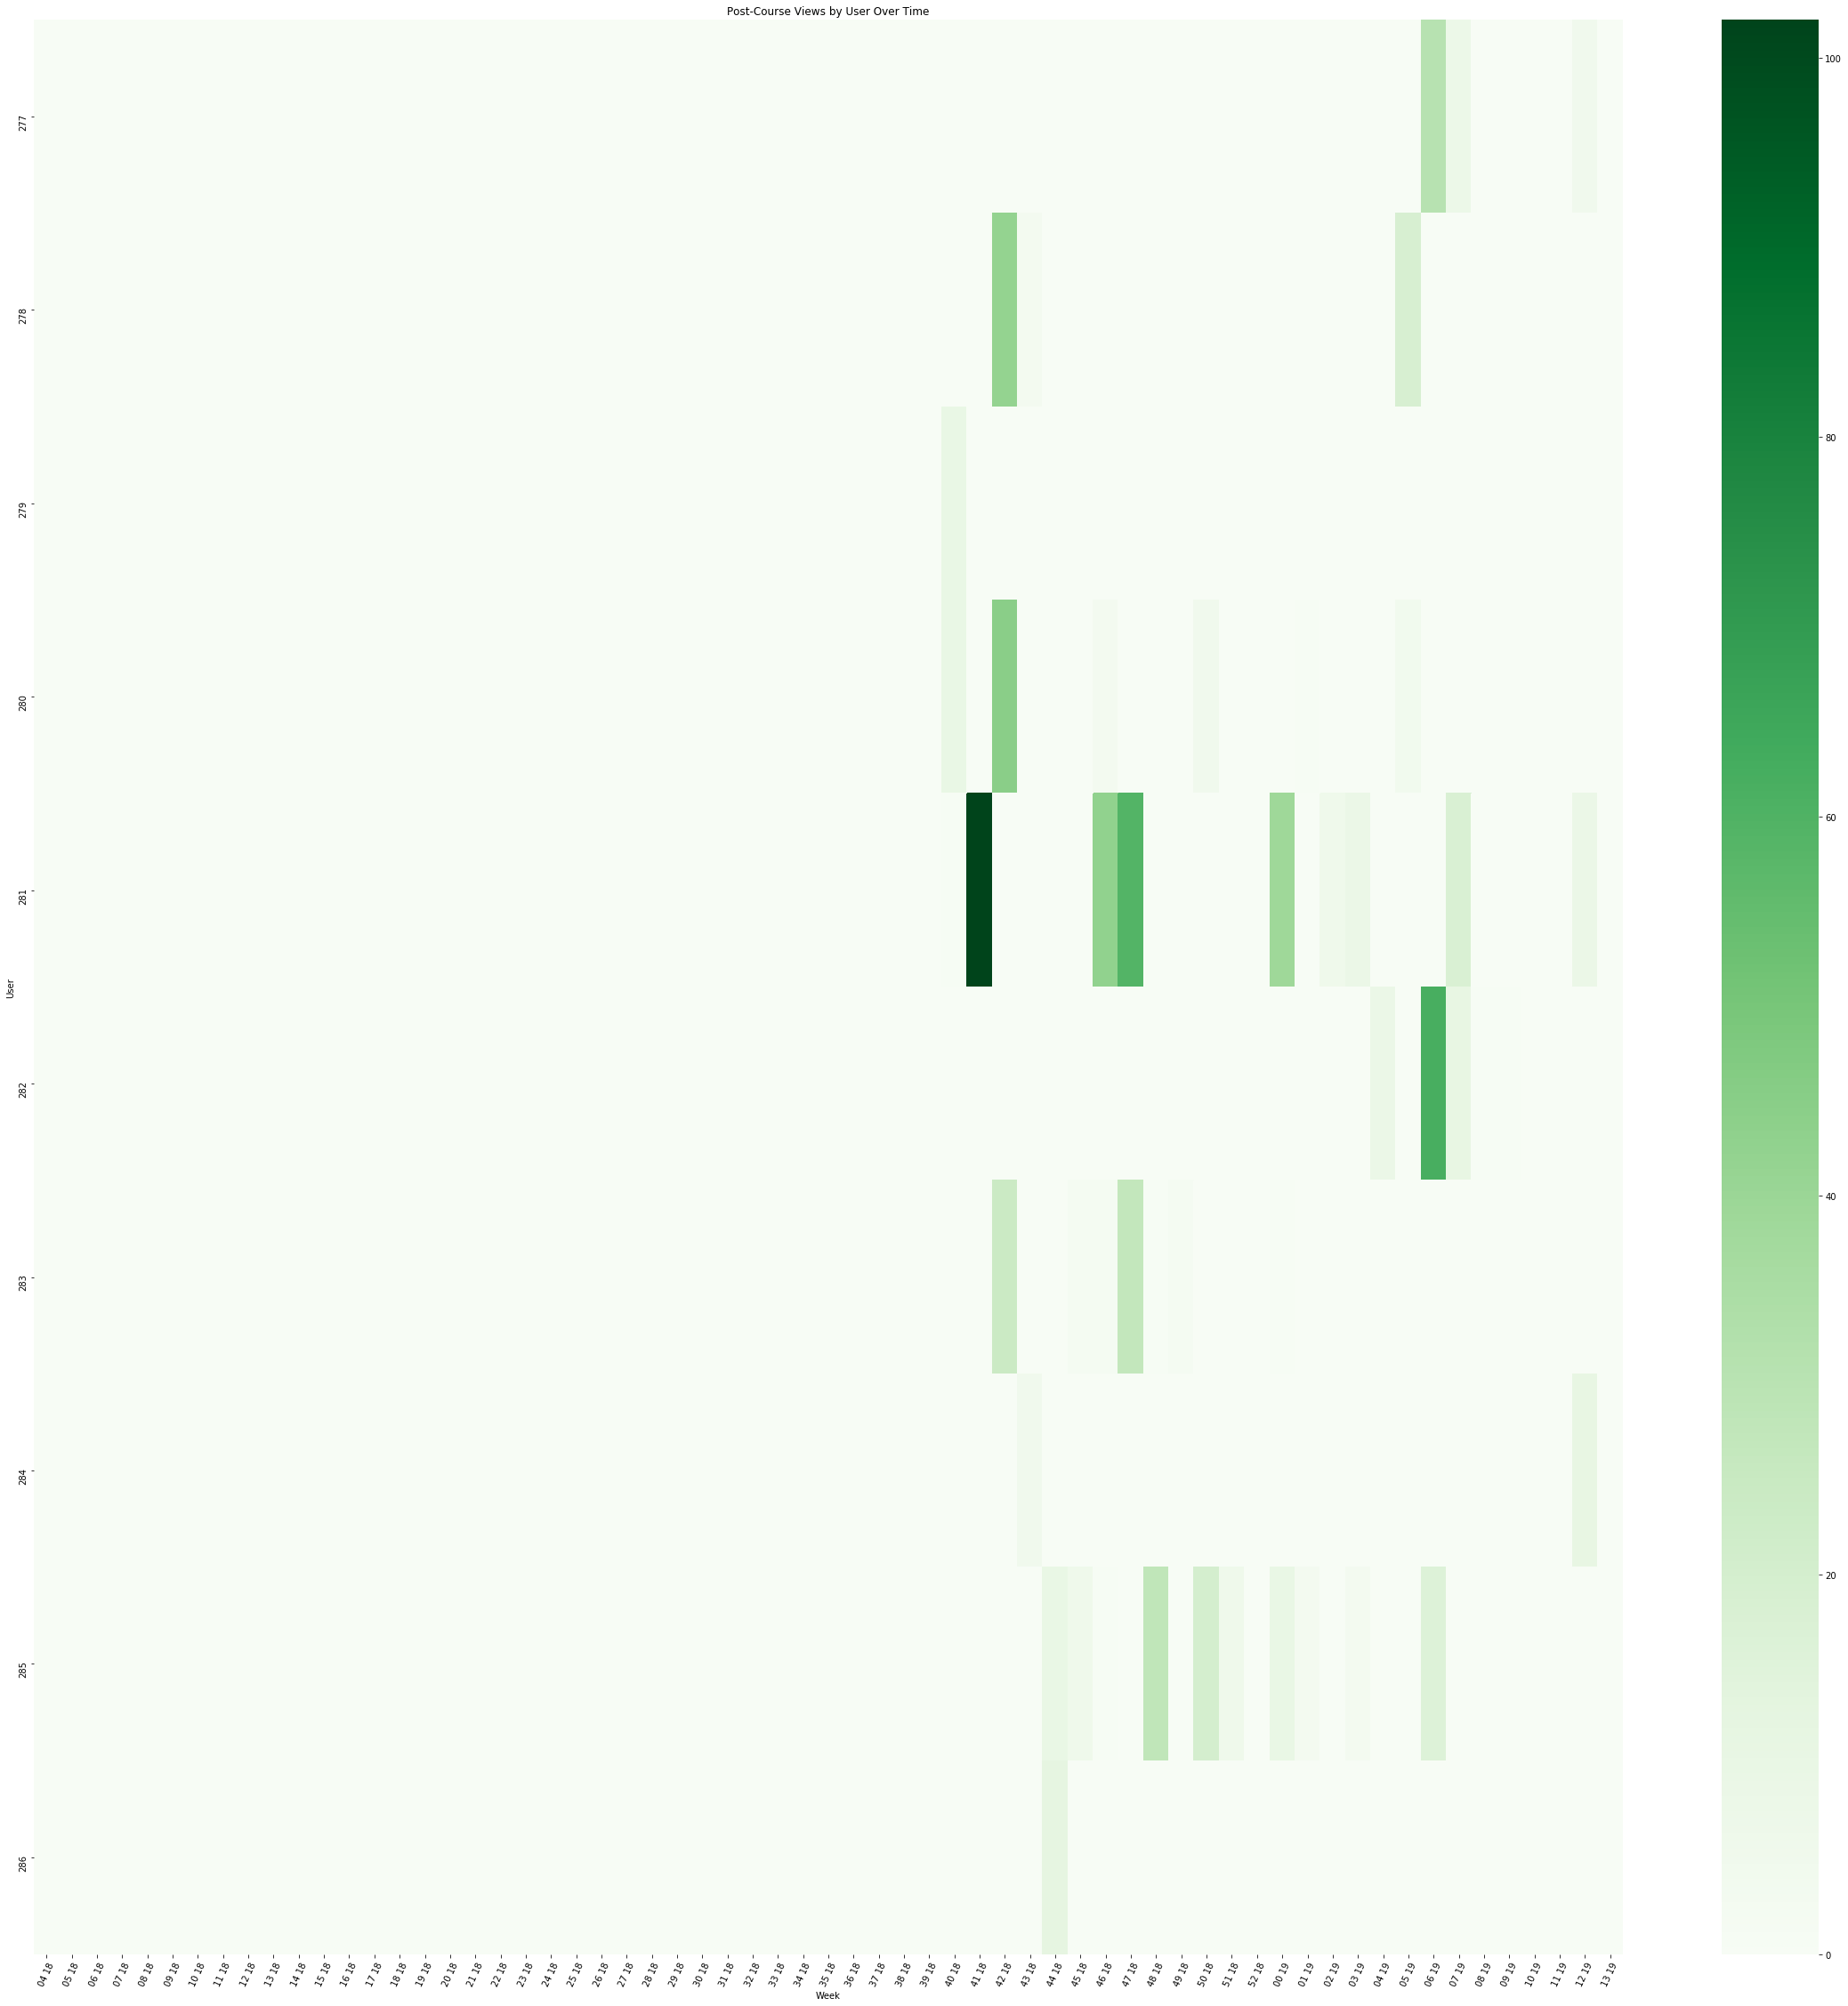

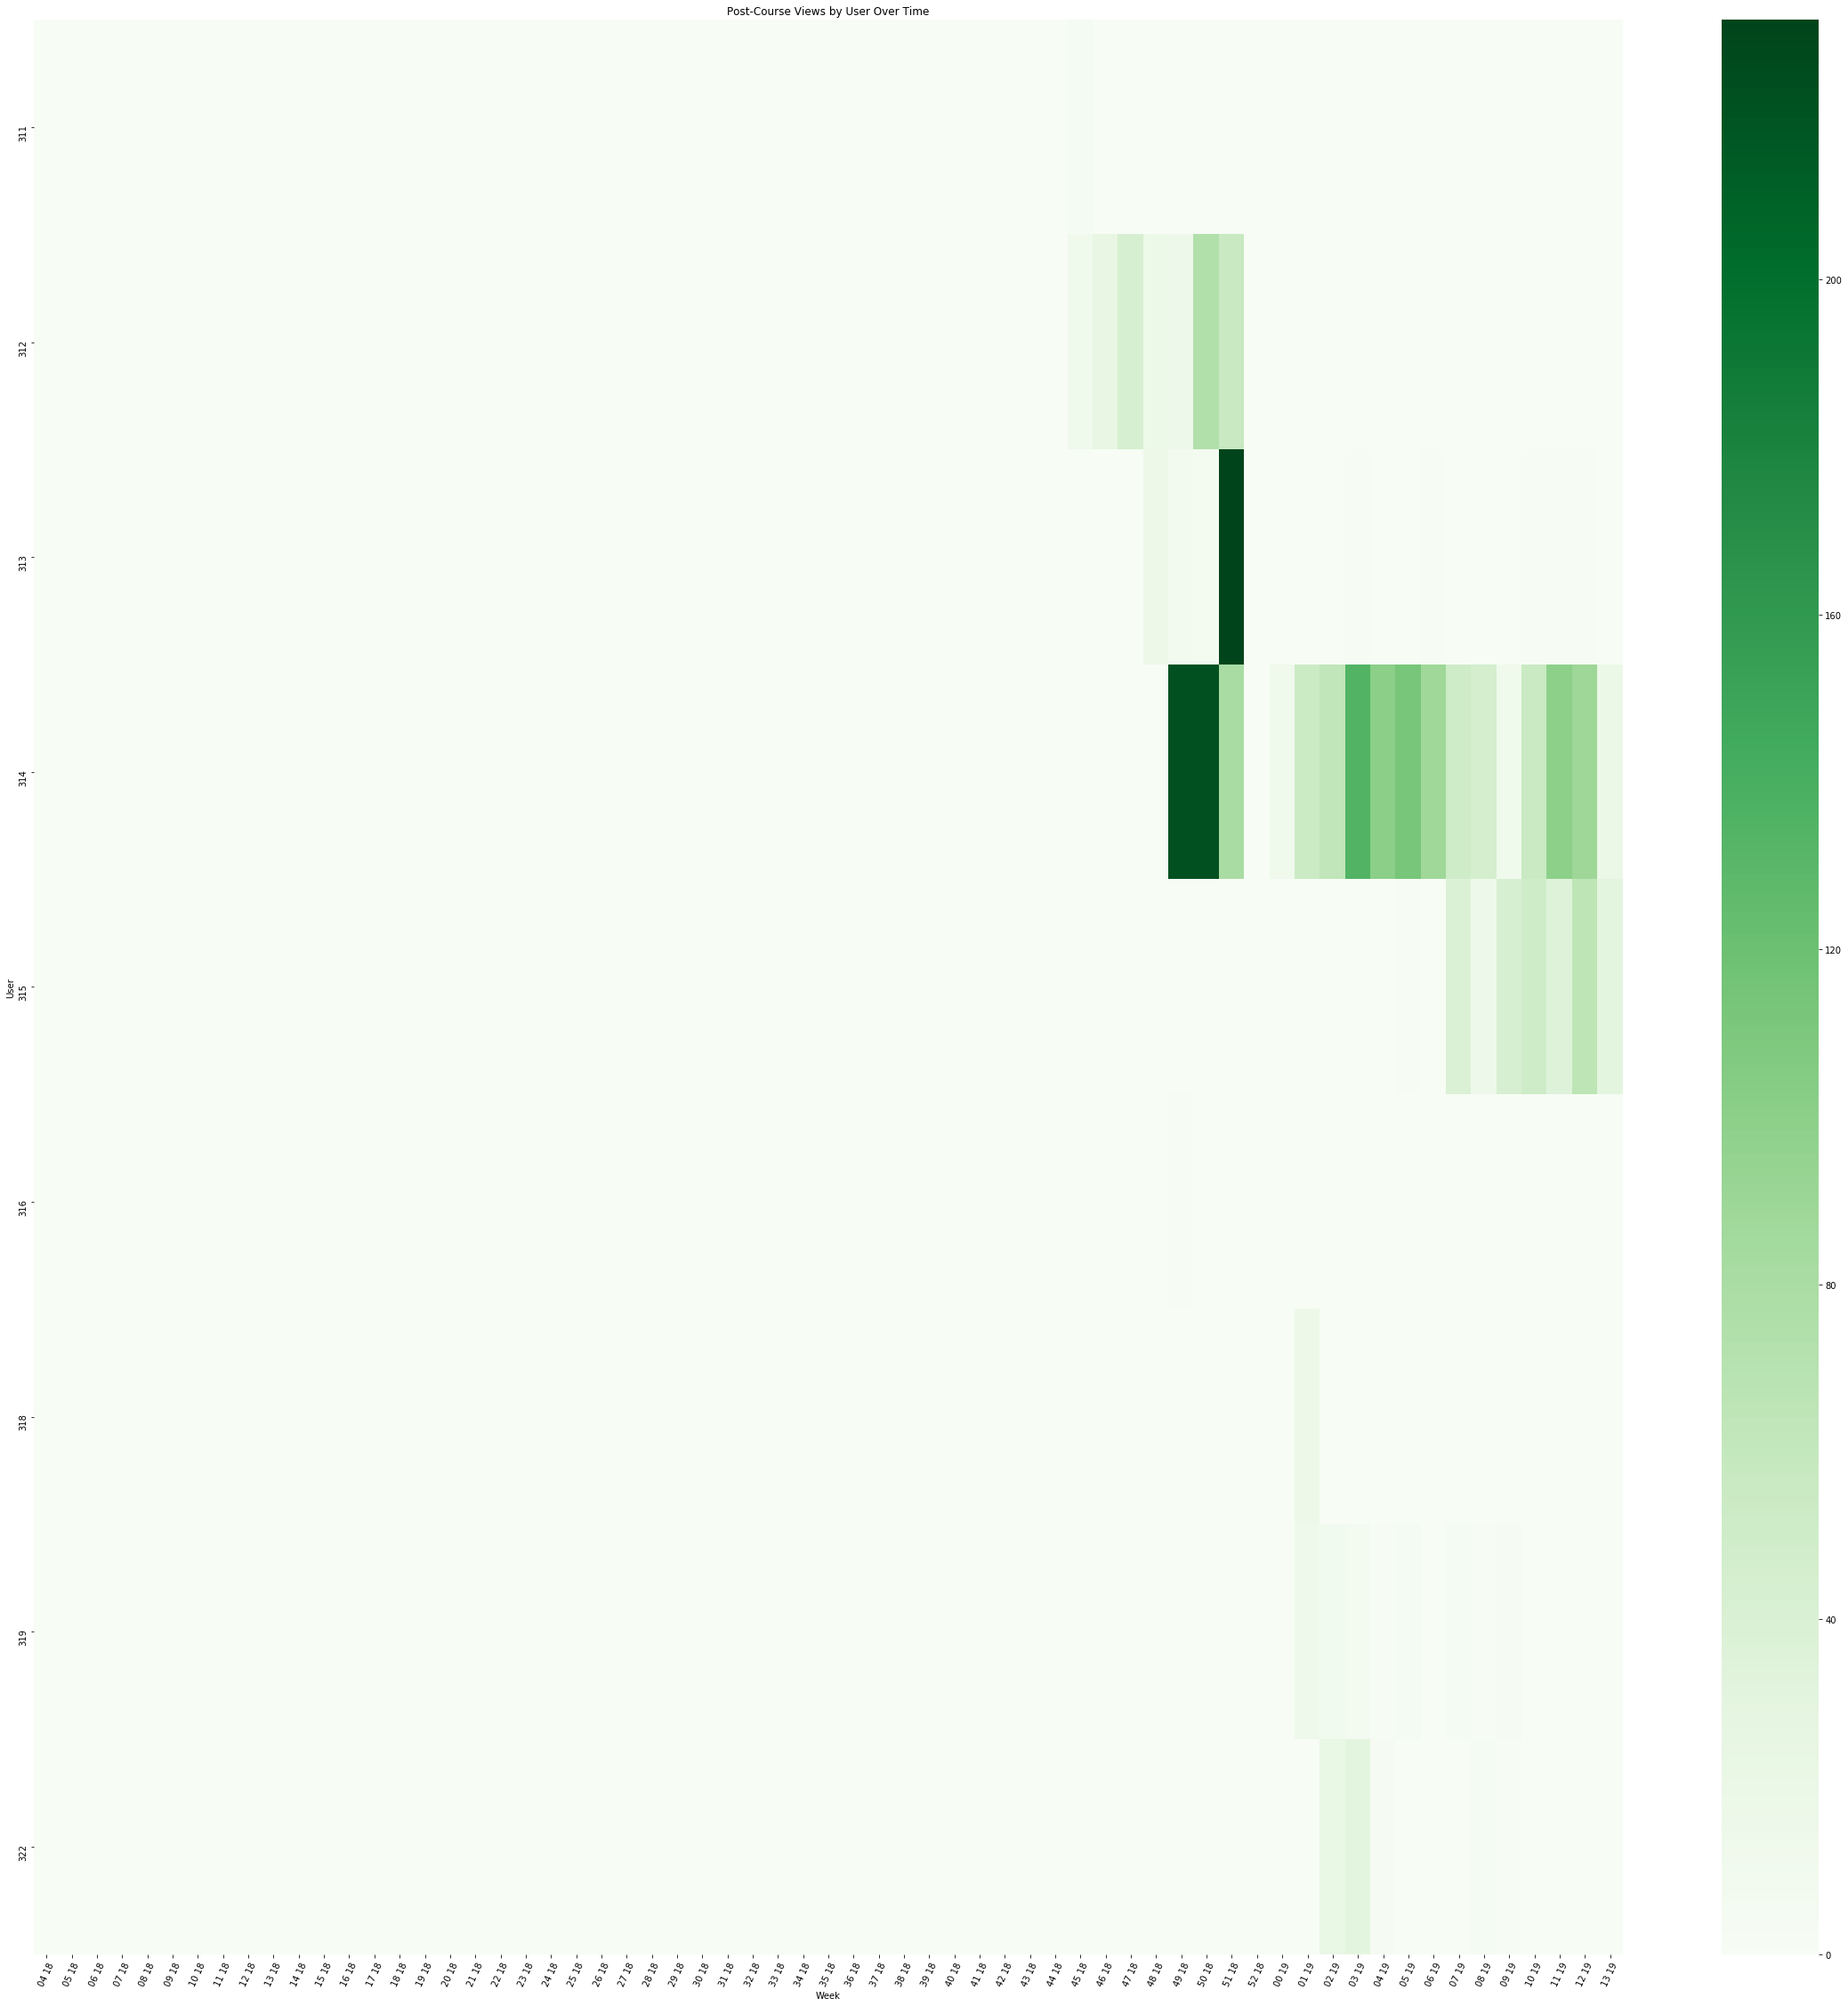

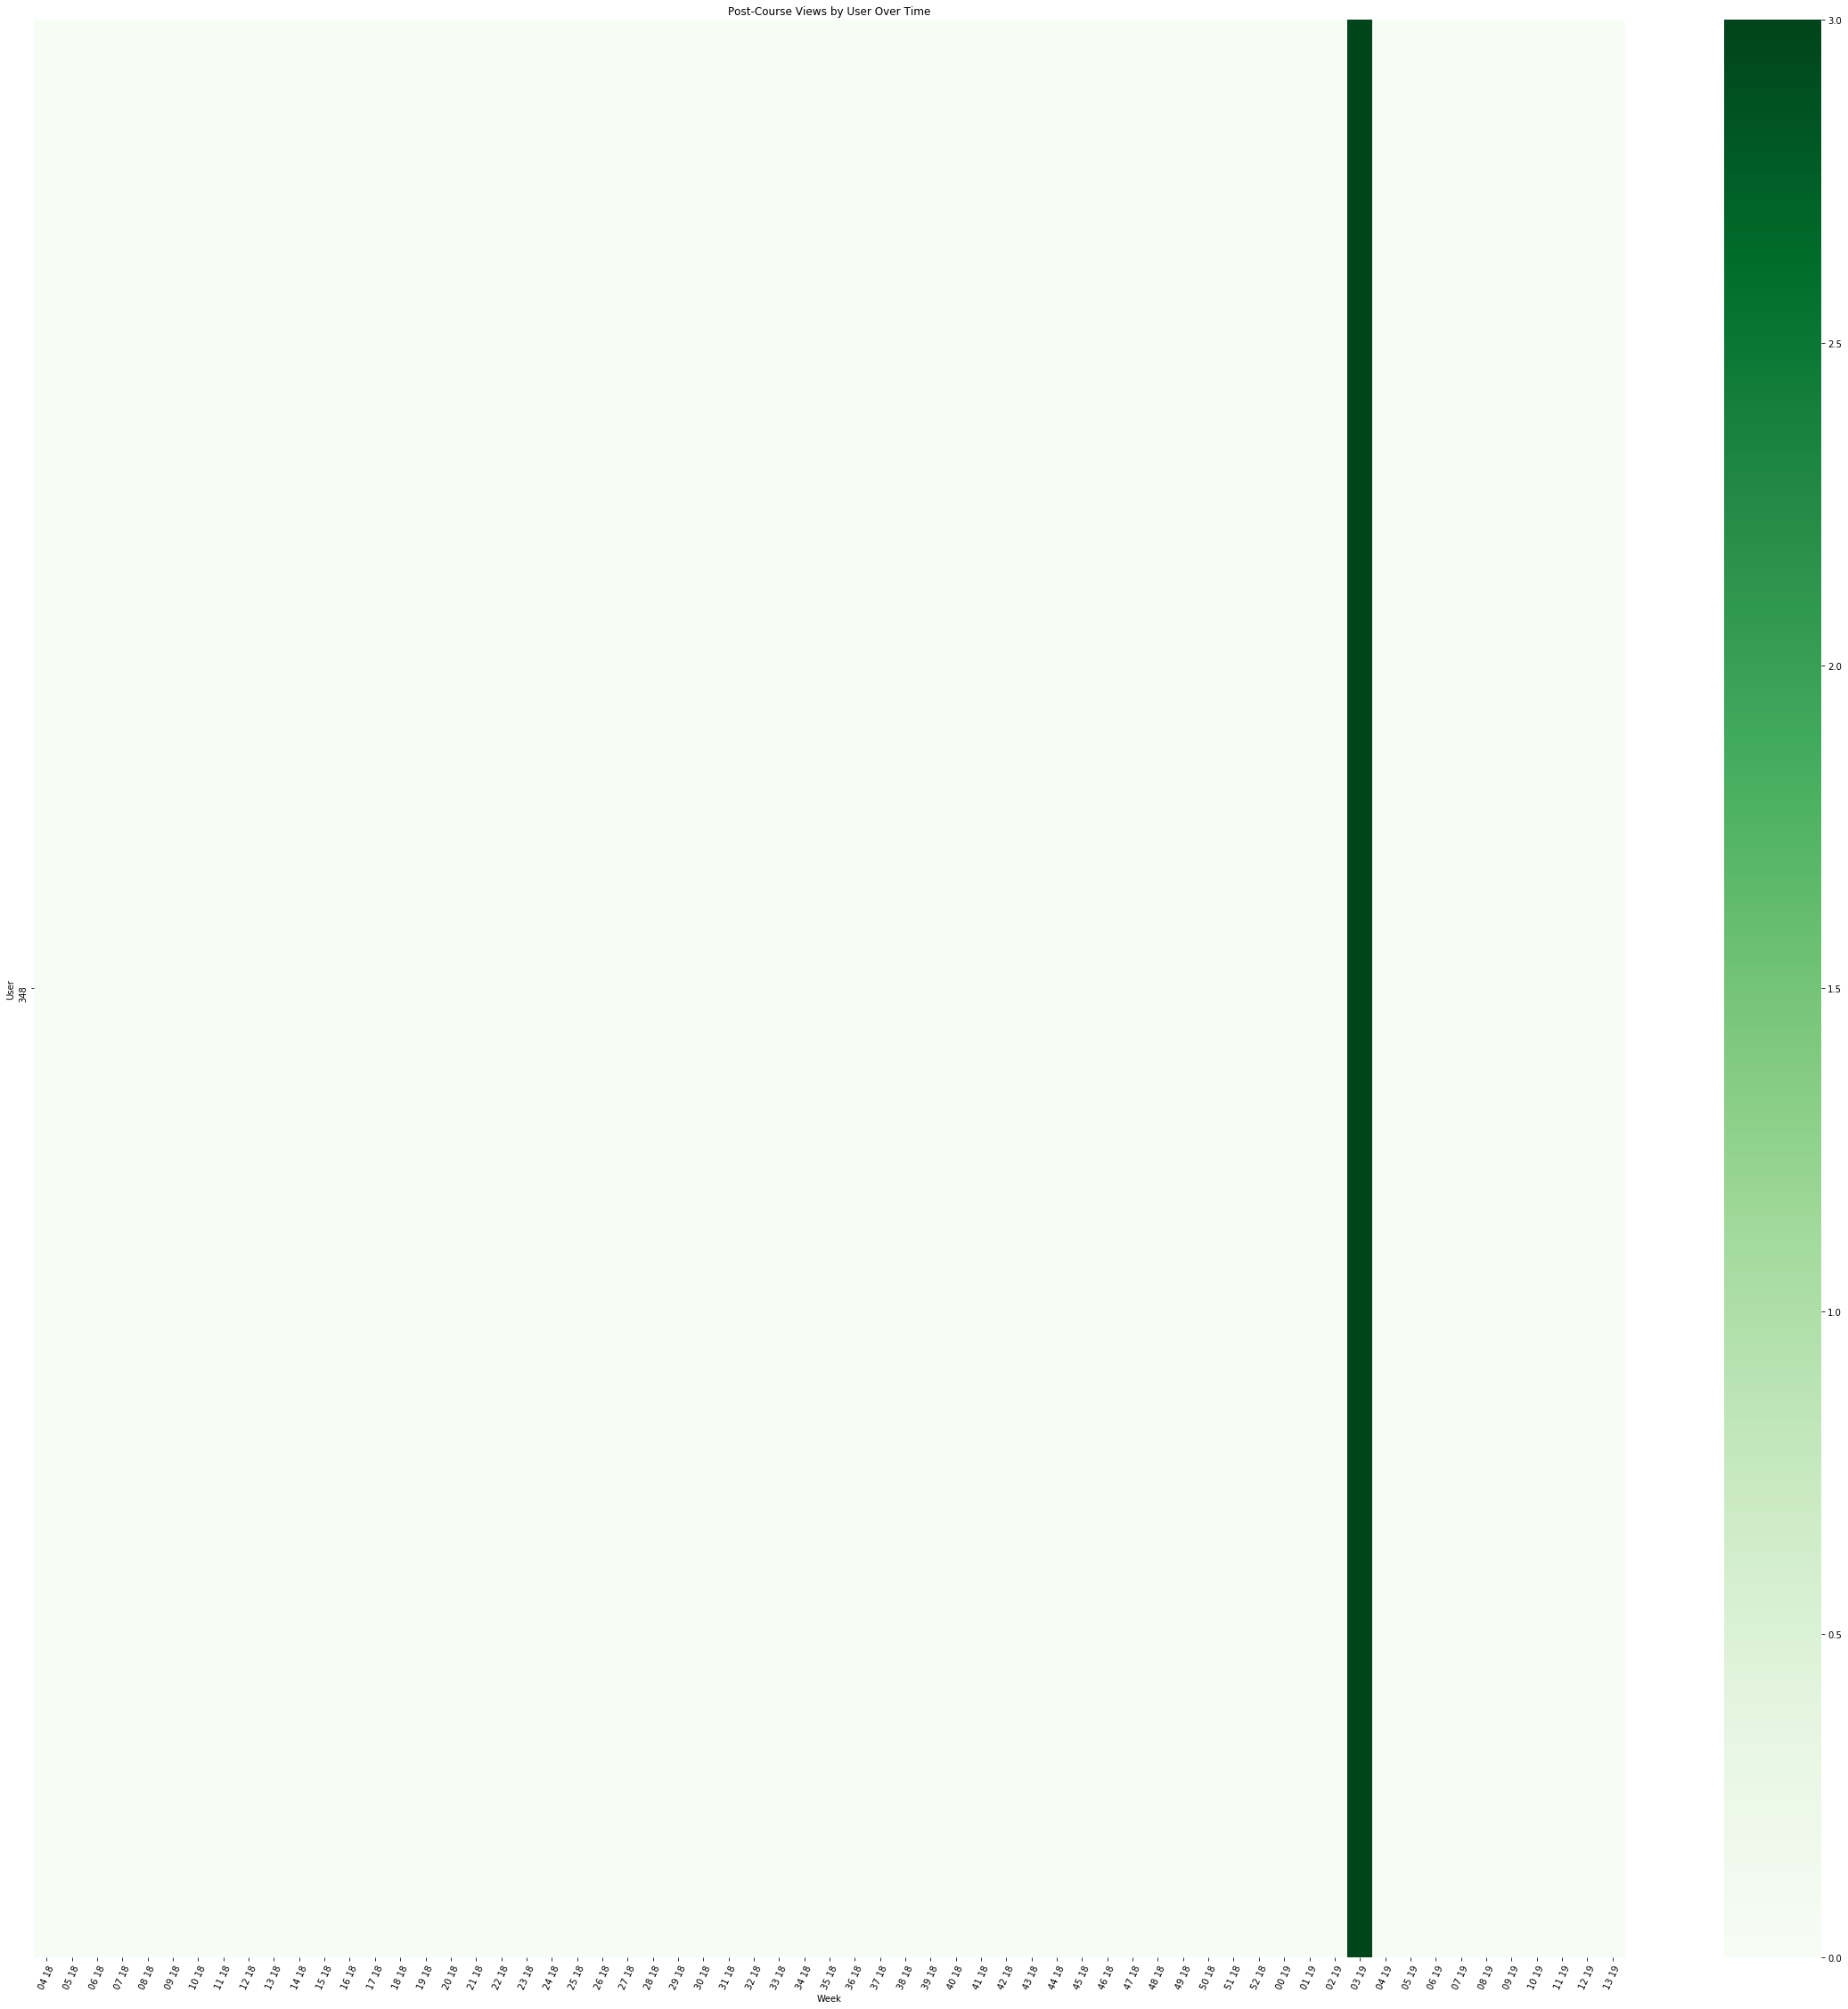

In [20]:
list_blocks = [0, 25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300, 325]
for el in list_blocks:
    us_views_by_week = user_views.resample('W').sum().loc[:, el+1:el+25]
    plt.figure(figsize=(40,40))
    sns.heatmap(us_views_by_week.T, cmap='Greens')
    # assign ticks and labels from plot
    ticks, labels = plt.xticks()
    # remake labels using datetime formatting that is preferable
    labels = us_views_by_week.index.strftime('%W %y')
    # reassign xticks with new labels
    plt.xticks(ticks, labels)
    # rotate xticks
    plt.xticks(ticks, labels, rotation=65)
    # label y axis
    plt.ylabel('User')
    # label x axis
    plt.xlabel('Week')
    # label title
    plt.title('Post-Course Views by User Over Time')

In [21]:
df[df.user_id == 314][df.after_course==1].ip.value_counts()

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


97.105.19.58       1261
108.73.55.208        89
192.171.117.210      26
68.134.170.110       16
12.189.101.90        16
108.199.117.106      13
184.203.221.94        8
173.149.158.44        7
70.121.200.203        6
173.127.80.231        5
67.10.185.18          4
99.203.213.32         4
184.226.95.31         3
173.127.11.100        3
173.127.10.4          2
173.123.52.37         2
173.123.121.68        1
12.208.132.3          1
173.127.91.200        1
Name: ip, dtype: int64

In [22]:
# going back to df_agg after our visual exploration of outliers

In [23]:
df_agg.head()

,date,user_id,hits
0,2018-01-26,1,7
1,2018-01-26,11,19
2,2018-01-26,21,2
3,2018-01-26,26,3
4,2018-01-26,37,4


In [24]:
students = list(df_agg.user_id.unique())

In [25]:
dfa = df_agg.set_index('date').rename(index=str, columns={'hits':'ema'})

In [26]:
def bollinger_bands(df):
    ema = df.ewm(span=14, adjust=False).mean()
    ema['stdev'] = ema.ema.rolling(14).std()
    ema['ub'] = ema.ema + ema.stdev*3
    ema['lb'] = ema.ema - ema.stdev*3
    return ema.reset_index()

In [27]:
bands = []
for student in students:
    bb = bollinger_bands(dfa[dfa.user_id == student])
    bands.append(bb)

df2 = pd.concat(bands)

In [28]:
df_missing = df2[df2.stdev.isnull()][['user_id','ema']]
df_missing.head()

,user_id,ema
0,1.0,7.000000
1,1.0,6.200000
2,1.0,6.173333
3,1.0,6.016889
4,1.0,6.014637


In [29]:
df_missing = df_missing.groupby('user_id').std().fillna(value=0).reset_index().rename(index=str, columns={'ema': 'stdev_null'})
df_missing.head()

,user_id,stdev_null
0,1.0,0.392210
1,3.0,1.023435
2,5.0,1.853203
3,6.0,3.920433
4,7.0,1.498262


In [30]:
df2 = df2.merge(df_missing, on='user_id', how='left')

In [31]:
df2.head()

,date,user_id,ema,stdev,ub,lb,stdev_null
0,2018-01-26 00:00:00,1.0,7.000000,NaN,NaN,NaN,0.39221
1,2018-01-27 00:00:00,1.0,6.200000,NaN,NaN,NaN,0.39221
2,2018-01-29 00:00:00,1.0,6.173333,NaN,NaN,NaN,0.39221
3,2018-01-30 00:00:00,1.0,6.016889,NaN,NaN,NaN,0.39221
4,2018-01-31 00:00:00,1.0,6.014637,NaN,NaN,NaN,0.39221


In [32]:
idx = df2.stdev.isnull()
df2.loc[idx,'stdev'] = df2.loc[idx,'stdev_null']
df2 = df2.drop(columns='stdev_null')

In [33]:
idx = df2.ub.isnull()
df2.loc[idx,'ub'] = df2.loc[idx,'ema'] + df2.loc[idx,'stdev']*3
df2.loc[idx,'lb'] = df2.loc[idx,'ema'] - df2.loc[idx,'stdev']*3

In [34]:
idx = df2.ub == df2.lb
df2.loc[idx,'ub'] = df2.loc[idx,'ub'] + .01
df2.loc[idx,'lb'] = df2.loc[idx,'lb'] - .01

In [35]:
df2.date = pd.to_datetime(df2.date)

In [36]:
df_agg.date = pd.to_datetime(df_agg.date)

In [37]:
df2 = df2.merge(df_agg, on=['user_id', 'date'], how='left')

In [38]:
df2.head()

,date,user_id,ema,stdev,ub,lb,hits
0,2018-01-26,1.0,7.000000,0.39221,8.176630,5.823370,7
1,2018-01-27,1.0,6.200000,0.39221,7.376630,5.023370,1
2,2018-01-29,1.0,6.173333,0.39221,7.349963,4.996704,6
3,2018-01-30,1.0,6.016889,0.39221,7.193519,4.840259,5
4,2018-01-31,1.0,6.014637,0.39221,7.191267,4.838007,6


In [39]:
df2['pct_b'] = (df2.hits-df2.lb)/(df2.ub-df2.lb)
df2 = df2.drop(columns=['stdev'])
df2.head()

,date,user_id,ema,ub,lb,hits,pct_b
0,2018-01-26,1.0,7.000000,8.176630,5.823370,7,0.500000
1,2018-01-27,1.0,6.200000,7.376630,5.023370,1,-1.709701
2,2018-01-29,1.0,6.173333,7.349963,4.996704,6,0.426343
3,2018-01-30,1.0,6.016889,7.193519,4.840259,5,0.067881
4,2018-01-31,1.0,6.014637,7.191267,4.838007,6,0.493780


In [40]:
df2[df2.pct_b>1].user_id.value_counts()

11.0     64
53.0     63
64.0     59
1.0      48
211.0    46
26.0     23
41.0     21
40.0     20
50.0     17
60.0     16
127.0    16
153.0    14
10.0     13
314.0    12
142.0    10
186.0    10
27.0     10
128.0     9
67.0      9
248.0     9
96.0      8
110.0     8
56.0      8
52.0      8
315.0     8
312.0     7
36.0      7
72.0      7
252.0     6
37.0      6
         ..
136.0     1
370.0     1
210.0     1
283.0     1
102.0     1
16.0      1
29.0      1
22.0      1
178.0     1
280.0     1
164.0     1
19.0      1
284.0     1
228.0     1
140.0     1
272.0     1
109.0     1
264.0     1
198.0     1
126.0     1
257.0     1
65.0      1
313.0     1
254.0     1
242.0     1
105.0     1
269.0     1
173.0     1
160.0     1
267.0     1
Name: user_id, Length: 137, dtype: int64

In [51]:
group_after_course = df[['user_id','after_course']].groupby('user_id').sum()

In [55]:
group_after_course[group_after_course.after_course == 0].shape[0]

121

In [42]:
df.head()

,date,page_viewed,user_id,cohort_id,ip,name,start_date,end_date,after_course
0,2018-01-26,/,1,8,97.105.19.61,Hampton,2015-09-22,2016-02-06,1
1,2018-01-26,java-ii,1,8,97.105.19.61,Hampton,2015-09-22,2016-02-06,1
2,2018-01-26,java-ii/object-oriented-programming,1,8,97.105.19.61,Hampton,2015-09-22,2016-02-06,1
3,2018-01-26,slides/object_oriented_programming,1,8,97.105.19.61,Hampton,2015-09-22,2016-02-06,1
4,2018-01-26,javascript-i/conditionals,2,22,97.105.19.61,Teddy,2018-01-08,2018-05-17,0


In [71]:
df['java' in df.page_viewed]

KeyError: False